In [1]:
# ============================================================================
# PROJECT FOLDER STRUCTURE
# ============================================================================
# game-behavior-analytics/
# ├── data_analysis_notebook/
# │   └── analysis(PL+SM).ipynb
# ├── data/
# │   └── final_dataset.csv

# Change to the correct directory
%cd game-behavior-analytics/data_analysis_notebook/ 

/Users/suvadeep.mukherjee/Documents/game-behavior-intervention-study/game-behavior-analytics/data_analysis_notebook


/opt/anaconda3/envs/cheating_env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Setup and Data Preparation

In [2]:

# ============================================================================
# LIBRARY IMPORTS
# ============================================================================

import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import os
import seaborn as sns

os.getcwd()

'/Users/suvadeep.mukherjee/Documents/game-behavior-intervention-study/game-behavior-analytics/data_analysis_notebook'

### DATA PREPARATION

In [3]:
df = pd.read_csv("../data/final_dataset.csv")

# Create categorical cheating behavior variable
def cheating_behavior(cheating_rate):
    return 0 if cheating_rate == 0 else (2 if cheating_rate == 1 else 1)  # Non-cheater=0, Partial cheater=1, Full cheater=2

df["cheating_behavior"] = df["cheating_rate_main_round"].apply(cheating_behavior)  # algorithm is in {game-behavior-analytics/cheating_analysis/cheating_analyzer.py}
df["experience"] = (df["task_satisfaction"] + df["task_engagement"]) / 2  # average of task satisfaction and task engagement
df["performance"] = df["performance_score_including_cheated_words"]  # performance includes legitimate + cheated words

# Drop rows with missing key outcome or predictor variables
df = df.dropna(subset=['cheating_behavior', 'performance', 'experience', 'concept', 'motivational_message_id'])


# Prepare data splits
control_data = df[df['concept'] == 'control']
intervention_data = df[df['concept'] != 'control']

# We use this naming convention:
# Intervention (1=concept-based message shown; 0=control) → Concept (15 concepts from 4 theories) → Motivational Message (3 variations per concept)

concept_ids = df['concept'].astype('category')
if concept_ids.cat.categories[0] != 'control':
    concept_ids = concept_ids.cat.reorder_categories(['control'] + [c for c in concept_ids.cat.categories if c != 'control'])
concept_codes = concept_ids.cat.codes.values
concepts = [c for c in concept_ids.cat.categories if c != 'control']

message_ids = df['motivational_message_id'].astype('category')
message_codes = message_ids.cat.codes.values

# Extract outcome and predictor arrays
y_cheating_behavior = df['cheating_behavior'].values
y_performance = df['performance'].values
y_experience = df['experience'].values
is_partialCheater, is_fullCheater = (y_cheating_behavior == 1).astype(int), (y_cheating_behavior == 2).astype(int)

# Standard deviations
perf_std, exp_std = np.std(y_performance), np.std(y_experience)

# Control group baselines
control_data = df[df['concept'] == 'control']
control_cheating_dist = control_data['cheating_behavior'].value_counts(normalize=True).sort_index()
control_performance = control_data['performance'].mean()
control_experience = control_data['experience'].mean()




### Explorative Analysis: through Visualization of potential source of cheaters in intervention groups from control's performance distribution

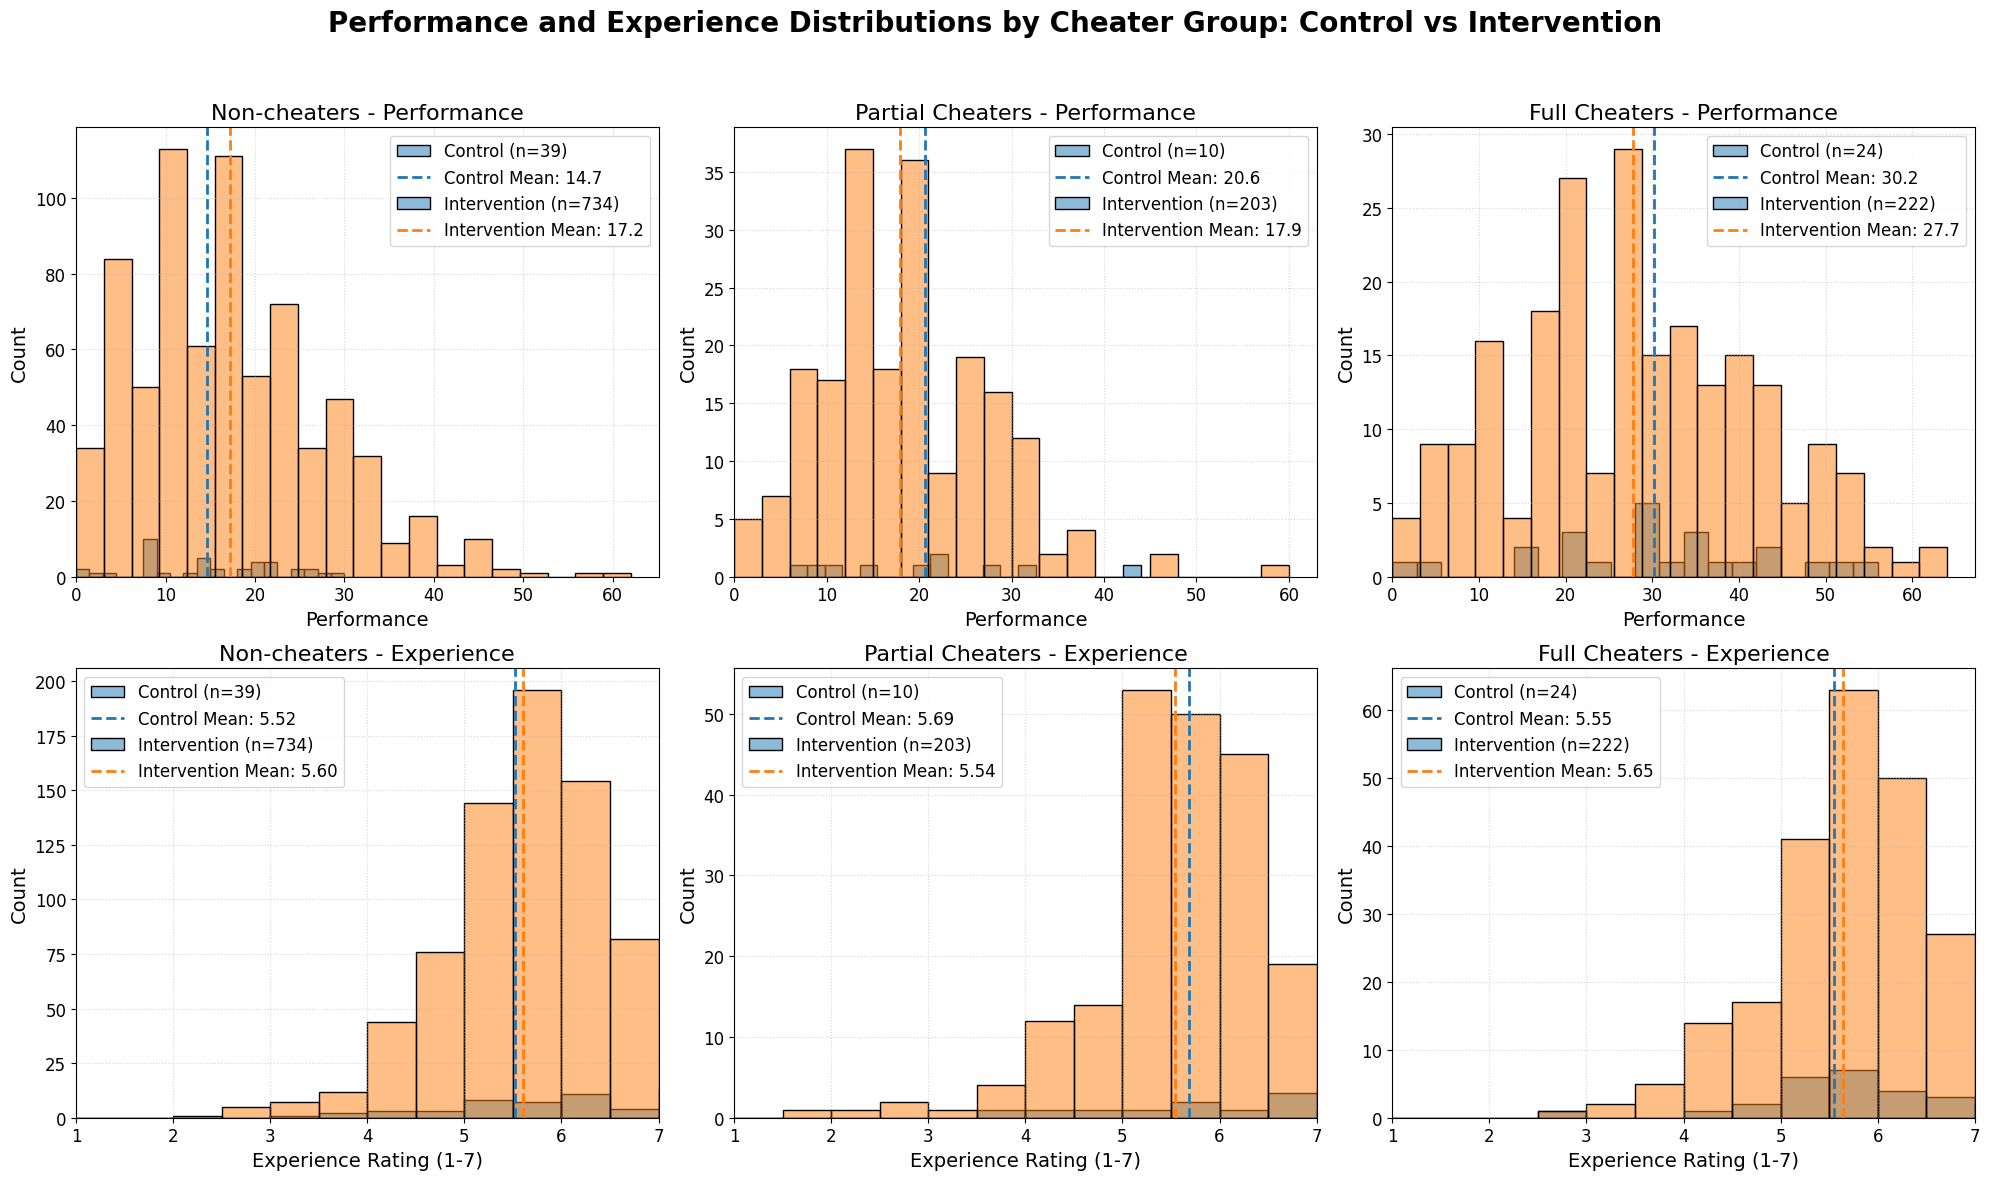

In [5]:
# =======================================================================================
# PERFORMANCE AND EXPERIENCE DISTRIBUTIONS FOR CONTROL vs INTERVENTION GROUPS
# =======================================================================================

# Define labels and colors
cheating_labels = {0: 'Non-cheaters', 1: 'Partial Cheaters', 2: 'Full Cheaters'}
colors = ['#2E8B57', '#FF8C00', '#DC143C']
category_colors = {'Low Performer': '#8dd3c7', 'Medium Performer': "#6f6f00", 'High Performer': '#bebada'}
control_color = '#1f77b4'
intervention_color = '#ff7f0e'

# Function to plot overall performance for a cheater group
def plot_cheater_group_performance(ax, control_df, intervention_df, cheat_cat):
    label = cheating_labels[cheat_cat]
    
    control_subset = control_df[control_df['cheating_behavior'] == cheat_cat]['performance'].dropna()
    control_subset = control_subset[control_subset >= 0]
    
    intervention_subset = intervention_df[intervention_df['cheating_behavior'] == cheat_cat]['performance'].dropna()
    intervention_subset = intervention_subset[intervention_subset >= 0]
    
    handles = []
    labels = []
    
    # Plot histogram for control
    if len(control_subset) >= 3:
        hist = sns.histplot(control_subset, ax=ax, bins=20, color=control_color, alpha=0.5, 
                            edgecolor='black')
        mean_val = control_subset.mean()
        mean_line = ax.axvline(mean_val, color=control_color, linestyle='--', linewidth=2)
        
        handles.extend([hist.patches[0], mean_line])
        labels.extend([f"Control (n={len(control_subset)})", f"Control Mean: {mean_val:.1f}"])
    
    # Plot histogram for intervention
    if len(intervention_subset) >= 3:
        hist = sns.histplot(intervention_subset, ax=ax, bins=20, color=intervention_color, alpha=0.5, 
                            edgecolor='black')
        mean_val = intervention_subset.mean()
        mean_line = ax.axvline(mean_val, color=intervention_color, linestyle='--', linewidth=2)
        
        handles.extend([hist.patches[0], mean_line])
        labels.extend([f"Intervention (n={len(intervention_subset)})", f"Intervention Mean: {mean_val:.1f}"])
    
    ax.set_title(f"{label} - Performance", fontsize=16)
    ax.set_xlabel("Performance", fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlim(left=0)
    ax.legend(handles=handles, labels=labels, fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.5)

# Function to plot overall experience for a cheater group
def plot_cheater_group_experience(ax, control_df, intervention_df, cheat_cat):
    label = cheating_labels[cheat_cat]
    
    control_subset = control_df[control_df['cheating_behavior'] == cheat_cat]['experience'].dropna()
    control_subset = control_subset[(control_subset >= 1) & (control_subset <= 7)]
    
    intervention_subset = intervention_df[intervention_df['cheating_behavior'] == cheat_cat]['experience'].dropna()
    intervention_subset = intervention_subset[(intervention_subset >= 1) & (intervention_subset <= 7)]
    
    handles = []
    labels = []
    
    # Plot histogram for control
    if len(control_subset) >= 3:
        hist = sns.histplot(control_subset, ax=ax, bins=np.arange(1, 8, 0.5), color=control_color, alpha=0.5, 
                            edgecolor='black')
        mean_val = control_subset.mean()
        mean_line = ax.axvline(mean_val, color=control_color, linestyle='--', linewidth=2)
        
        handles.extend([hist.patches[0], mean_line])
        labels.extend([f"Control (n={len(control_subset)})", f"Control Mean: {mean_val:.2f}"])
    
    # Plot histogram for intervention
    if len(intervention_subset) >= 3:
        hist = sns.histplot(intervention_subset, ax=ax, bins=np.arange(1, 8, 0.5), color=intervention_color, alpha=0.5, 
                            edgecolor='black')
        mean_val = intervention_subset.mean()
        mean_line = ax.axvline(mean_val, color=intervention_color, linestyle='--', linewidth=2)
        
        handles.extend([hist.patches[0], mean_line])
        labels.extend([f"Intervention (n={len(intervention_subset)})", f"Intervention Mean: {mean_val:.2f}"])
    
    ax.set_title(f"{label} - Experience", fontsize=16)
    ax.set_xlabel("Experience Rating (1-7)", fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlim(1, 7)
    ax.legend(handles=handles, labels=labels, fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.5)

# =======================================================================================
# PLOTTING 2x3 GRID: Row 1 = Performance; Row 2 = Experience
# =======================================================================================

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle("Performance and Experience Distributions by Cheater Group: Control vs Intervention", fontsize=20, fontweight='bold')

# Row 1: Performance distributions
for i, cheat_cat in enumerate([0, 1, 2]):
    plot_cheater_group_performance(axes[0, i], control_data, intervention_data, cheat_cat)

# Row 2: Experience distributions
for i, cheat_cat in enumerate([0, 1, 2]):
    plot_cheater_group_experience(axes[1, i], control_data, intervention_data, cheat_cat)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Skipped cell
<!-- #### Interpretation of the results above:

1. High performers can have **biggest impacts by interventions**
    - In the control, ~70% of high performers were full cheaters. Under intervention, this dropped dramatically to ~40% (↓30%).
    - The non-cheater proportion among high performers nearly tripled (~18% → ~47%). That ~30% could have moved from full cheaters to non-cheaters.
    - Interpretation: 
        - The interventions substantially could reduce cheating among high performers. It suggests that high performers might have the skills to achieve high scores without cheating but chose to cheat in control.
        - Under interventions (e.g. motivational messaging), they may choose honesty over maximizing scores without sacrificing experience (ΔExperience ≈ 0).

2. Medium performers can show **smaller cheating reductions**, but can show interesting patterns:
    - Full cheaters among medium performers reduced slightly (~23% → ~15%), a -8% change.
    - Partial cheaters increased (~14% → 20%, +6%).
    - Interpretation: 
        - Some full cheaters may have downgraded to partial cheating, and a small portion could become fully honest (non-cheaters ↑~2%).
        - Experience ratings for full cheaters in this group increased by +0.55, suggesting that interventions might have been helping them to be better engaged and satisfied.

3. Low performers were already **mostly honest**
    - Both in control and intervention, ~75% were non-cheaters. Very little change in cheating behavior:
        - Full cheaters reduced by only ~2%.
        - Partial cheaters increased by ~4% (from non-cheaters or full cheaters).
    - Experience: Low performer partial cheaters experienced a 1-point drop in experience under intervention.
        - This might imply: Messaging or intervention-induced guilt or inadequacy feelings among low performers who still cheated partially.


#### Key Takeaways:
##### Our interventions may not make weaker players cheat more if they are already mostly honest. The most notable effect we could see among high performers, where cheating can drastically be reduced under interventions without harming their experience. This suggests that behavioral interventions can transform those with the greatest capacity to cheat without diminishing their task engagement or satisfaction. -->

### Model 1: Cheating Behavior (Multinomial Logistic)

#### What this model does:
- Predicts probability of being non-cheater (reference), partial cheater, or full cheater
- Compares control group vs individual concepts using multinomial logistic regression

#### What we are looking for:
- Do interventions reduce cheating compared to control?
- Which concepts are most effective at reducing different types of cheating?
- Separate effects for partial vs full cheating behavior


In [6]:
# Model 1 data preparation - Cheating Behavior

# Calculate control group uncertainty based on actual sample sizes
control_counts = control_data['cheating_behavior'].value_counts().sort_index()
print("Control group counts:", control_counts.values)

# Calculate empirical log-odds and their standard errors
n_total = control_counts.sum()
n_non = control_counts[0]
n_partial = control_counts[1] 
n_full = control_counts[2]

# Logits for partialcheaters vs noncheaters, fullcheaters vs noncheaters
control_partialcheaters_logit = np.log(n_partial / n_non) if n_non > 0 else -2
control_fullcheaters_logit = np.log(n_full / n_non) if n_non > 0 else -1

# Standard errors for log-odds using delta method
# SE(log(p1/p0)) ≈ sqrt(1/n1 + 1/n0) where n1, n0 are counts
se_partialcheaters = np.sqrt(1/n_partial + 1/n_non) if n_partial > 0 and n_non > 0 else 1.0
se_fullcheaters = np.sqrt(1/n_full + 1/n_non) if n_full > 0 and n_non > 0 else 1.0

print(f"Control partial vs non log-odds: {control_partialcheaters_logit:.3f} ± {se_partialcheaters:.3f}")
print(f"Control full vs non log-odds: {control_fullcheaters_logit:.3f} ± {se_fullcheaters:.3f}")

Control group counts: [39 10 24]
Control partial vs non log-odds: -1.361 ± 0.354
Control full vs non log-odds: -0.486 ± 0.259


## Concepts → Outcomes


MODEL 1: CHEATING BEHAVIOR (MULTINOMIAL LOGISTIC)
Fitting multinomial cheating behavior model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_partialcheaters_intercept, beta_fullcheaters_intercept, concept_effects_partialcheaters, concept_effects_fullcheaters, message_effects_partialcheaters, message_effects_fullcheaters]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.
Sampling: [cheating_obs]


Output()

Model fitted successfully!
Performing posterior predictive checks...


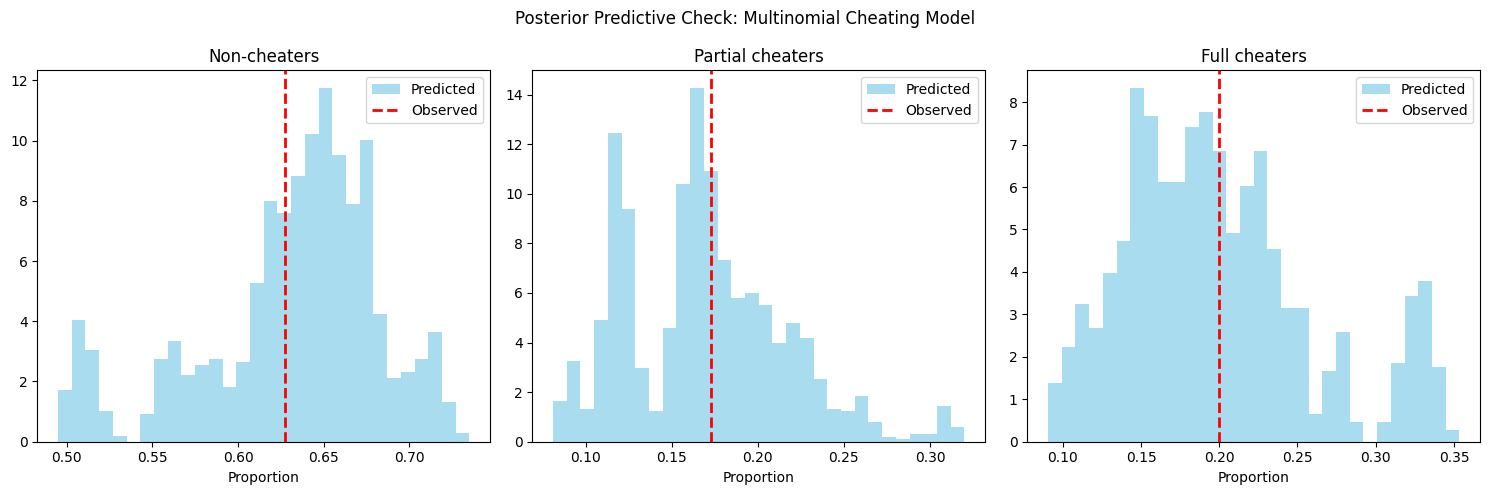

In [7]:
# ============================================================================
# MODEL 1: CHEATING BEHAVIOR (Multinomial Logistic)
#
# Multinomial logistic regression with non-cheaters as reference category:
#
# log_odds(partialcheaters vs noncheaters) = β₀_partialcheaters + Σ(β_i_partialcheaters × ConceptDummy_i) + message_effects_partialcheaters
# log_odds(fullcheaters vs noncheaters) = β₀_fullcheaters + Σ(β_i_fullcheaters × ConceptDummy_i) + message_effects_fullcheaters
#
# Where:
# - β₀: Control group baseline log-odds for each cheating type vs non-cheating
# - β_i: Effect of concept i on each cheating type (vs control)
# - message_effects: Random effects for motivational message variations
# ============================================================================

print("\n" + "="*80)
print("MODEL 1: CHEATING BEHAVIOR (MULTINOMIAL LOGISTIC)")
print("="*80)

with pm.Model() as cheating_model:
    
    # Control group baseline using empirical uncertainty
    beta_partialcheaters_intercept = pm.Normal('beta_partialcheaters_intercept', mu=control_partialcheaters_logit, sigma=se_partialcheaters)
    beta_fullcheaters_intercept = pm.Normal('beta_fullcheaters_intercept', mu=control_fullcheaters_logit, sigma=se_fullcheaters)
    
    # Concept effects on partialcheaters and fullcheaters cheating (vs non-cheating)
    concept_effects_partialcheaters = pm.Normal('concept_effects_partialcheaters', mu=-1.0, sigma=1.0, shape=len(concepts))
    concept_effects_fullcheaters = pm.Normal('concept_effects_fullcheaters', mu=-1.0, sigma=1.0, shape=len(concepts))
    
    # Message effects
    message_effects_partialcheaters = pm.Normal('message_effects_partialcheaters', mu=0, sigma=0.5, shape=len(message_ids.cat.categories))
    message_effects_fullcheaters = pm.Normal('message_effects_fullcheaters', mu=0, sigma=0.5, shape=len(message_ids.cat.categories))
    
    # Linear predictors (single expression)
    eta_partialcheaters = (beta_partialcheaters_intercept + message_effects_partialcheaters[message_codes] + 
                           pm.math.switch(concept_codes > 0, 
                            concept_effects_partialcheaters[concept_codes - 1], 0))
    
    eta_fullcheaters = (beta_fullcheaters_intercept + message_effects_fullcheaters[message_codes] +
                       pm.math.switch(concept_codes > 0, 
                        concept_effects_fullcheaters[concept_codes - 1], 0))
    
    # Multinomial logistic probabilities
    # Reference category is non-cheating (category 0), hence reference logit = 0
    logits = pm.math.stack([pm.math.zeros(eta_partialcheaters.shape), eta_partialcheaters, eta_fullcheaters], axis=1) 
    probs = pm.math.softmax(logits, axis=1)
    
    # Likelihood
    pm.Categorical('cheating_obs', p=probs, observed=y_cheating_behavior)

print("Fitting multinomial cheating behavior model...")
with cheating_model:
    trace_cheating = pm.sample(1000, tune=500, chains=4, cores=4, target_accept=0.9, random_seed=42)

print("Model fitted successfully!")

# Model checking
print("Performing posterior predictive checks...")
with cheating_model:
    ppc_cheating = pm.sample_posterior_predictive(trace_cheating, random_seed=42)


# Plot posterior predictive checks
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, category in enumerate(['Non-cheaters', 'Partial cheaters', 'Full cheaters']):
    observed_prop = (y_cheating_behavior == i).mean()
    predicted_props = (ppc_cheating.posterior_predictive['cheating_obs'] == i).mean(dim=['chain', 'draw'])
    
    axes[i].hist(predicted_props, bins=30, alpha=0.7, density=True, label='Predicted', color='skyblue')
    axes[i].axvline(observed_prop, color='red', linestyle='--', linewidth=2, label='Observed')
    axes[i].set_title(f'{category}')
    axes[i].set_xlabel('Proportion')
    axes[i].legend()

plt.suptitle('Posterior Predictive Check: Multinomial Cheating Model')
plt.tight_layout()
plt.show()


In [ ]:
az.summary(trace_cheating)

In [ ]:
# ============================================================================
# GRAPHICAL REPRESENTATION AND ROBUST CHECKING OF MODEL 1
# ============================================================================
# graph = pm.model_to_graphviz(cheating_model)
# graph.render('cheating_model_graph', format='png')
display(pm.model_to_graphviz(cheating_model))
display(az.plot_ppc(ppc_cheating, num_pp_samples=100))

### Model 2: CONDITIONAL MODEL SELECTION FOR PERFORMANCE AND EXPERIENCE
#### What this model does:
- Predicts performance scores and experience ratings while accounting for cheating behavior differences
- Uses empirically-derived control group baselines calculated from actual control data by cheating category:
    - Performance: Calculated as control_means_perf = [mean for each cheating category] from observed data
    - Experience: Calculated as control_means_exp = [mean for each cheating category] from observed data
- Includes concept x cheating interactions to capture how interventions work differently for each cheating group
- Conditional modeling approach:
    - IF performance-experience correlation exists (≥3 groups with |r|>0.1): Uses multivariate model with correlation ρ
    - ELSE: Models performance and experience separately (independent models)

#### What we are looking for:
- Do interventions affect performance/experience differently for non-cheaters vs cheaters?
- Are there trade-offs? (e.g., concepts that reduce cheating but harm performance)
- Which concepts optimize all outcomes? (reduce cheating + maintain/improve performance + enhance experience)
- How strong is the performance-experience relationship? (correlation ρ)
- Concept-specific interaction effects: Do some concepts work better for certain cheating groups?


In [12]:
# Model 2 data preparation - Performance and Experience

# Calculate actual control group means by cheating category
control_means_perf = []
control_means_exp = []

for cheat_cat in [0, 1, 2]:
    control_subset = control_data[control_data['cheating_behavior'] == cheat_cat]
    
    if len(control_subset) > 0:
        perf_mean = control_subset['performance'].mean()
        exp_mean = control_subset['experience'].mean()
    else:
        # Fallback if no observations
        perf_mean = control_performance  # Overall control mean
        exp_mean = control_experience
    
    control_means_perf.append(perf_mean)
    control_means_exp.append(exp_mean)

print("Control group means by cheating category:")
print(f"Performance: {control_means_perf}")
print(f"Experience: {control_means_exp}")

# Calculate correlations and store results
corr_results = []
cheating_labels = {0: 'Non-cheaters', 1: 'Partial cheaters', 2: 'Full cheaters'}

for group_name, group_df in [('Control', control_data), ('Intervention', intervention_data)]:
    for cheat_cat in [0, 1, 2]:
        subset = group_df[group_df['cheating_behavior'] == cheat_cat]
        if len(subset) >= 10:
            corr = subset[['performance', 'experience']].corr().iloc[0, 1]
        else:
            corr = None  # Insufficient data
        corr_results.append({
            'Group': group_name,
            'Cheating Category': cheating_labels[cheat_cat],
            'n': len(subset),
            'Correlation': round(corr, 3) if corr is not None else 'NA'
        })

# Convert to DataFrame for table display
corr_table = pd.DataFrame(corr_results)
print("\nCorrelation table between performance and experience by group and cheating category:")
print(corr_table.to_string(index=False))

# Decision criterion
significant_corrs = sum(
    1 for row in corr_results
    if isinstance(row['Correlation'], float) and abs(row['Correlation']) > 0.1 and row['n'] >= 10
)
use_multivariate = significant_corrs >= 3

print(f"\nDecision: {significant_corrs}/6 groups have |r|>0.1")
print(f"Using {'multivariate' if use_multivariate else 'separate'} model(s)")


Control group means by cheating category:
Performance: [np.float64(14.666666666666666), np.float64(20.6), np.float64(30.25)]
Experience: [np.float64(5.51897435897436), np.float64(5.6865000000000006), np.float64(5.546041666666667)]

Correlation table between performance and experience by group and cheating category:
       Group Cheating Category   n  Correlation
     Control      Non-cheaters  39        0.339
     Control  Partial cheaters  10       -0.427
     Control     Full cheaters  24        0.203
Intervention      Non-cheaters 734        0.115
Intervention  Partial cheaters 203        0.006
Intervention     Full cheaters 222        0.222

Decision: 5/6 groups have |r|>0.1
Using multivariate model(s)



MODEL 2: CONDITIONAL MODEL SELECTION WITH CONTROL GROUP INTERCEPTS
Fitting multivariate model...


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_exp_control, mu_perf_control, concept_exp_main, concept_perf_main, concept_exp_interactions, concept_perf_interactions, msg_exp, msg_perf, sigma_exp, sigma_perf, rho]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 149 seconds.
Sampling: [outcomes]


Output()

Experience-Performance correlation: 0.123 [0.066, 0.176]
Model 2 Complete

Posterior predictive checks for multivariate model...


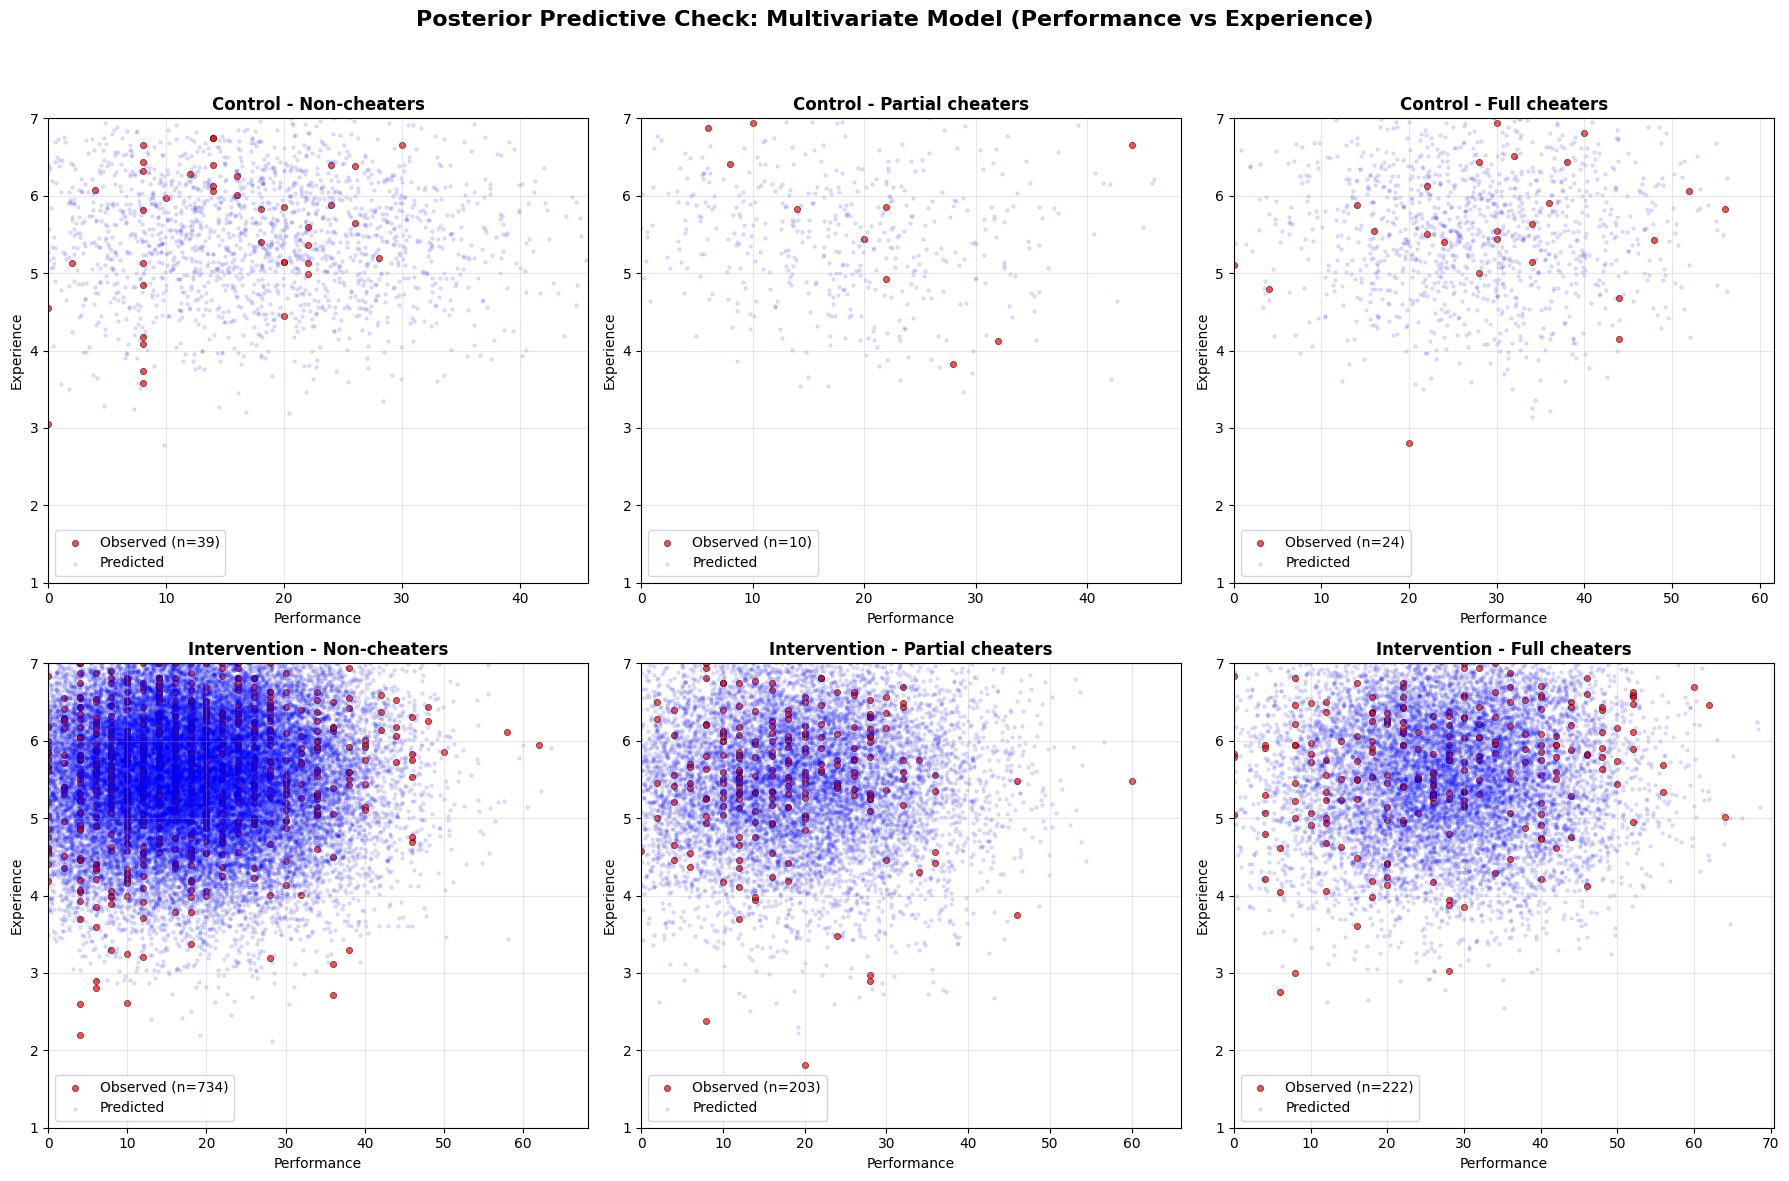

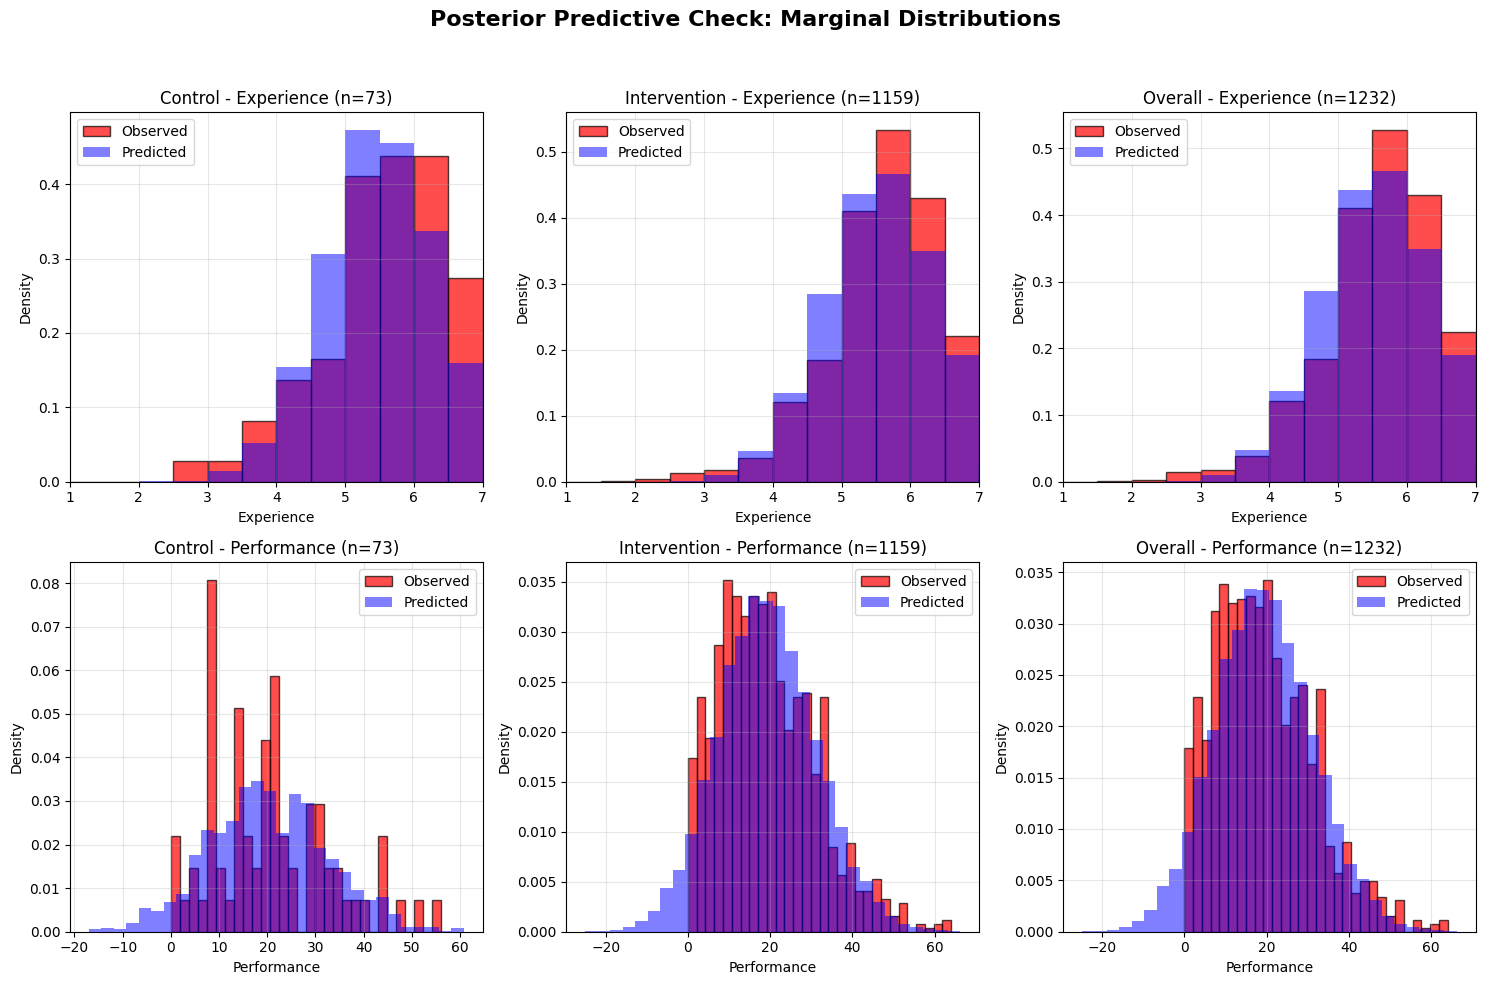

In [13]:
# ============================================================================
# MODEL 2: CONDITIONAL MODEL SELECTION FOR PERFORMANCE AND EXPERIENCE
#
# IF correlation exists (≥3 groups with |r|>0.1):
#   MULTIVARIATE MODEL:
#   Performance = β₀_perf[cheating_cat] + Σ(β_i_perf × ConceptDummy_i) 
#               + Σ(β_i_perf_cheat × ConceptDummy_i × CheatingCat)
#               + message_effects_perf + ε_perf
#   
#   Experience = β₀_exp[cheating_cat] + Σ(β_i_exp × ConceptDummy_i) 
#              + Σ(β_i_exp_cheat × ConceptDummy_i × CheatingCat)
#              + message_effects_exp + ε_exp
#   
#   With covariance: Cov(ε_perf, ε_exp) = ρ × σ_perf × σ_exp
#
# ELSE:
#   SEPARATE MODELS:
#   Same equations but modeled independently (ρ = 0)
#
# Where:
# - β₀[cheating_cat]: Control baselines by cheating category
# - β_i: Main concept effects vs control  
# - β_i_cheat: Concept × cheating category interactions
# - ρ: Performance-experience correlation (multivariate only)
# ============================================================================

print("\n" + "="*80)
print("MODEL 2: CONDITIONAL MODEL SELECTION WITH CONTROL GROUP INTERCEPTS")
print("="*80)

if use_multivariate:
    # ========================================================================
    # MULTIVARIATE MODEL: Performance + Experience with Correlation
    # ========================================================================
    
    with pm.Model() as multivariate_model:
        
        # Control baselines by cheating category
        mu_exp_control = pm.Normal('mu_exp_control', mu=control_means_exp, sigma=0.3, shape=3)
        mu_perf_control = pm.Normal('mu_perf_control', mu=control_means_perf, sigma=3.0, shape=3)
        
        # Concept effects (overall)
        concept_exp_main = pm.Normal('concept_exp_main', mu=0, sigma=0.2, shape=len(concepts))
        concept_perf_main = pm.Normal('concept_perf_main', mu=0, sigma=2.0, shape=len(concepts))
        
        # Concept effects (concept × cheating category)
        concept_exp_interactions = pm.Normal('concept_exp_interactions', mu=0, sigma=0.15, shape=(len(concepts), 3))
        concept_perf_interactions = pm.Normal('concept_perf_interactions', mu=0, sigma=1.5, shape=(len(concepts), 3))
        
        # Message effects
        msg_exp = pm.Normal('msg_exp', mu=0, sigma=0.5, shape=len(message_ids.cat.categories))
        msg_perf = pm.Normal('msg_perf', mu=0, sigma=0.5, shape=len(message_ids.cat.categories))
        
        # Linear predictors
        mu_exp = (mu_exp_control[y_cheating_behavior] + msg_exp[message_codes] + 
          pm.math.switch(concept_codes > 0,
                        concept_exp_main[concept_codes - 1] + concept_exp_interactions[concept_codes - 1, y_cheating_behavior], 0))

        mu_perf = (mu_perf_control[y_cheating_behavior] + msg_perf[message_codes] + 
           pm.math.switch(concept_codes > 0,
                         concept_perf_main[concept_codes - 1] + concept_perf_interactions[concept_codes - 1, y_cheating_behavior], 0))
        
        # Covariance structure
        sigma_exp = pm.HalfNormal('sigma_exp', sigma=0.4)
        sigma_perf = pm.HalfNormal('sigma_perf', sigma=5.0)
        
        rho = pm.Uniform('rho', lower=-0.5, upper=0.5)
        
        cov = pm.math.stack([[sigma_exp**2, rho*sigma_exp*sigma_perf],
                            [rho*sigma_exp*sigma_perf, sigma_perf**2]])
        
        # Multivariate likelihood
        outcomes = pm.math.stack([y_experience, y_performance], axis=1)
        means = pm.math.stack([mu_exp, mu_perf], axis=1)
        pm.MvNormal('outcomes', mu=means, cov=cov, observed=outcomes)
    
    print("Fitting multivariate model...")
    with multivariate_model:
        trace_multivariate = pm.sample(1000, tune=500, chains=4, cores=1, target_accept=0.9, random_seed=42)
        ppc_multivariate = pm.sample_posterior_predictive(trace_multivariate, var_names=['outcomes'])
    
    # Extract effects
    exp_main = trace_multivariate.posterior['concept_exp_main'].values.reshape(-1, len(concepts))
    exp_int = trace_multivariate.posterior['concept_exp_interactions'].values.reshape(-1, len(concepts), 3)
    perf_main = trace_multivariate.posterior['concept_perf_main'].values.reshape(-1, len(concepts))
    perf_int = trace_multivariate.posterior['concept_perf_interactions'].values.reshape(-1, len(concepts), 3)
    rho_samples = trace_multivariate.posterior['rho'].values.flatten()
    
    print(f"Experience-Performance correlation: {rho_samples.mean():.3f} [{np.percentile(rho_samples, 2.5):.3f}, {np.percentile(rho_samples, 97.5):.3f}]")

else:
    # ========================================================================
    # SEPARATE MODELS: Performance and Experience Independently
    # ========================================================================
    
    # Experience Model
    with pm.Model() as experience_model:
        # UPDATED TO USE ACTUAL CONTROL VALUES
        mu_exp_control = pm.Normal('mu_exp_control', mu=control_means_exp, sigma=0.3, shape=3)
        concept_exp_main = pm.Normal('concept_exp_main', mu=0, sigma=0.2, shape=len(concepts))
        concept_exp_interactions = pm.Normal('concept_exp_interactions', mu=0, sigma=0.15, shape=(len(concepts), 3))
        msg_exp = pm.Normal('msg_exp', mu=0, sigma=0.1, shape=len(message_ids.cat.categories))
        
        mu_exp = mu_exp_control[y_cheating_behavior] + msg_exp[message_codes]
        mu_exp += pm.math.switch(concept_codes > 0,
                                concept_exp_main[concept_codes - 1] + concept_exp_interactions[concept_codes - 1, y_cheating_behavior], 0)
        
        pm.TruncatedNormal('experience_obs', mu=mu_exp, sigma=pm.HalfNormal('sigma_exp', sigma=0.4),
                          lower=1, upper=7, observed=y_experience)
    
    # Performance Model  
    with pm.Model() as performance_model:
        # UPDATED TO USE ACTUAL CONTROL VALUES
        mu_perf_control = pm.Normal('mu_perf_control', mu=control_means_perf, sigma=3.0, shape=3)
        concept_perf_main = pm.Normal('concept_perf_main', mu=0, sigma=2.0, shape=len(concepts))
        concept_perf_interactions = pm.Normal('concept_perf_interactions', mu=0, sigma=1.5, shape=(len(concepts), 3))
        msg_perf = pm.Normal('msg_perf', mu=0, sigma=1.0, shape=len(message_ids.cat.categories))
        
        mu_perf = mu_perf_control[y_cheating_behavior] + msg_perf[message_codes]
        mu_perf += pm.math.switch(concept_codes > 0,
                                 concept_perf_main[concept_codes - 1] + concept_perf_interactions[concept_codes - 1, y_cheating_behavior], 0)
        
        pm.TruncatedNormal('performance_obs', mu=mu_perf, sigma=pm.HalfNormal('sigma_perf', sigma=5.0),
                          lower=0, upper=y_performance.max() + 20, observed=y_performance)
    
    print("Fitting separate models...")
    with experience_model:
        trace_experience = pm.sample(1000, tune=500, chains=4, cores=1, target_accept=0.9, random_seed=42)
        ppc_experience = pm.sample_posterior_predictive(trace_experience, var_names=['experience_obs'])
    with performance_model:
        trace_performance = pm.sample(1000, tune=500, chains=4, cores=1, target_accept=0.9, random_seed=42)
        ppc_performance = pm.sample_posterior_predictive(trace_performance, var_names=['performance_obs'])
    
    # Extract effects
    exp_main = trace_experience.posterior['concept_exp_main'].values.reshape(-1, len(concepts))
    exp_int = trace_experience.posterior['concept_exp_interactions'].values.reshape(-1, len(concepts), 3)
    perf_main = trace_performance.posterior['concept_perf_main'].values.reshape(-1, len(concepts))
    perf_int = trace_performance.posterior['concept_perf_interactions'].values.reshape(-1, len(concepts), 3)
    
    print("Models fitted independently (no correlation estimated)")

print("Model 2 Complete")

# ============================================================================
# POSTERIOR PREDICTIVE CHECKS FOR MODEL 2
# ============================================================================

if use_multivariate:
    # For multivariate model
    print("\nPosterior predictive checks for multivariate model...")
    
    # Create comprehensive PPC plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    cheating_labels = {0: 'Non-cheaters', 1: 'Partial cheaters', 2: 'Full cheaters'}
    
    # Plot for each group (Control/Intervention) and cheating category
    plot_idx = 0
    for group_name in ['Control', 'Intervention']:
        for cheat_cat in [0, 1, 2]:
            row = plot_idx // 3
            col = plot_idx % 3
            ax = axes[row, col]
            
            if group_name == 'Control':
                mask = (df['concept'] == 'control') & (df['cheating_behavior'] == cheat_cat)
            else:
                mask = (df['concept'] != 'control') & (df['cheating_behavior'] == cheat_cat)
            
            if mask.sum() > 0:
                # Observed data
                obs_exp = y_experience[mask]
                obs_perf = y_performance[mask]
                
                # Predicted data - extract from multivariate outcomes
                pred_outcomes = ppc_multivariate.posterior_predictive['outcomes'].values  # Shape: (chains, draws, observations, 2)
                pred_exp = pred_outcomes[:, :, mask, 0].flatten()  # Experience is index 0
                pred_perf = pred_outcomes[:, :, mask, 1].flatten()  # Performance is index 1
                
                # Subsample predictions to avoid overplotting
                n_pred_samples = min(len(pred_exp), len(obs_exp) * 50)
                pred_exp_sub = np.random.choice(pred_exp, n_pred_samples, replace=False)
                pred_perf_sub = np.random.choice(pred_perf, n_pred_samples, replace=False)
                
                # Create 2D histograms/scatter plots
                ax.scatter(obs_perf, obs_exp, alpha=0.7, color='red', s=20, label=f'Observed (n={mask.sum()})', edgecolor='black', linewidth=0.5)
                ax.scatter(pred_perf_sub, pred_exp_sub, alpha=0.1, color='blue', s=5, label='Predicted', rasterized=True)
                
                ax.set_title(f'{group_name} - {cheating_labels[cheat_cat]}', fontweight='bold')
                ax.set_xlabel('Performance')
                ax.set_ylabel('Experience')
                ax.grid(True, alpha=0.3)
                ax.legend()
                
                # Set reasonable axis limits
                ax.set_xlim(0, max(obs_perf.max(), np.percentile(pred_perf_sub, 99)) * 1.1)
                ax.set_ylim(1, 7)
            
            plot_idx += 1
    
    plt.suptitle('Posterior Predictive Check: Multivariate Model (Performance vs Experience)', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    # Marginal distributions for experience and performance separately
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for outcome_idx, (outcome_name, outcome_data, ylim) in enumerate([
        ('Experience', y_experience, (1, 7)),
        ('Performance', y_performance, (0, y_performance.max() * 1.1))
    ]):
        for group_idx, (group_name, mask_func) in enumerate([
            ('Control', lambda: df['concept'] == 'control'),
            ('Intervention', lambda: df['concept'] != 'control'),
            ('Overall', lambda: np.ones(len(df), dtype=bool))
        ]):
            ax = axes[outcome_idx, group_idx]
            mask = mask_func()
            
            if mask.sum() > 0:
                # Observed
                obs_data = outcome_data[mask]
                
                # Predicted
                pred_data = ppc_multivariate.posterior_predictive['outcomes'].values[:, :, mask, outcome_idx].flatten()
                
                # Plot histograms
                if outcome_name == 'Experience':
                    bins = np.arange(1, 8, 0.5)
                else:
                    bins = 30
                
                ax.hist(obs_data, bins=bins, alpha=0.7, density=True, label='Observed', color='red', edgecolor='black')
                ax.hist(pred_data[:len(obs_data)*20], bins=bins, alpha=0.5, density=True, label='Predicted', color='blue')
                
                ax.set_title(f'{group_name} - {outcome_name} (n={mask.sum()})')
                ax.set_xlabel(outcome_name)
                ax.set_ylabel('Density')
                ax.set_ylim(0, None)
                if outcome_name == 'Experience':
                    ax.set_xlim(1, 7)
                ax.legend()
                ax.grid(True, alpha=0.3)
    
    plt.suptitle('Posterior Predictive Check: Marginal Distributions', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    # For separate models
    print("\nPosterior predictive checks for separate models...")
    
    # Experience model PPC
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    cheating_labels = {0: 'Non-cheaters', 1: 'Partial cheaters', 2: 'Full cheaters'}
    
    for i, (group, cheating_cat) in enumerate([(g, c) for g in ['Control', 'Intervention'] for c in [0, 1, 2]]):
        ax = axes[i//3, i%3]
        
        if group == 'Control':
            mask = (df['concept'] == 'control') & (df['cheating_behavior'] == cheating_cat)
        else:
            mask = (df['concept'] != 'control') & (df['cheating_behavior'] == cheating_cat)
        
        if mask.sum() > 0:
            obs_exp = y_experience[mask]
            pred_exp = ppc_experience.posterior_predictive['experience_obs'].values[:, :, mask].flatten()
            
            bins = np.arange(1, 8, 0.5)
            ax.hist(obs_exp, bins=bins, alpha=0.7, density=True, label='Observed', color='red', edgecolor='black')
            ax.hist(pred_exp[:len(obs_exp)*20], bins=bins, alpha=0.5, density=True, label='Predicted', color='blue')
            
            ax.set_title(f'{group} - {cheating_labels[cheating_cat]} (n={mask.sum()})')
            ax.set_xlabel('Experience')
            ax.set_xlim(1, 7)
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('PPC: Experience Model by Group & Cheating Category', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Performance model PPC
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    for i, (group, cheating_cat) in enumerate([(g, c) for g in ['Control', 'Intervention'] for c in [0, 1, 2]]):
        ax = axes[i//3, i%3]
        
        if group == 'Control':
            mask = (df['concept'] == 'control') & (df['cheating_behavior'] == cheating_cat)
        else:
            mask = (df['concept'] != 'control') & (df['cheating_behavior'] == cheating_cat)
        
        if mask.sum() > 0:
            obs_perf = y_performance[mask]
            pred_perf = ppc_performance.posterior_predictive['performance_obs'].values[:, :, mask].flatten()
            
            ax.hist(obs_perf, bins=20, alpha=0.7, density=True, label='Observed', color='red', edgecolor='black')
            ax.hist(pred_perf[:len(obs_perf)*20], bins=30, alpha=0.5, density=True, label='Predicted', color='blue')
            
            ax.set_title(f'{group} - {cheating_labels[cheating_cat]} (n={mask.sum()})')
            ax.set_xlabel('Performance')
            ax.set_xlim(0, None)
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('PPC: Performance Model by Group & Cheating Category', fontweight='bold')
    plt.tight_layout()
    plt.show()



In [ ]:
# ============================================================================
# GRAPHICAL REPRESENTATION AND ROBUST CHECKING OF MODEL 2
# ============================================================================
# graph = pm.model_to_graphviz(experience_model)
# graph.render('experience_model_graph', format='png')
if use_multivariate:
    display(pm.model_to_graphviz(multivariate_model))
    display(az.plot_ppc(ppc_multivariate, num_pp_samples=100))
else:
    display(pm.model_to_graphviz(performance_model))
    display(az.plot_ppc(ppc_performance, num_pp_samples=100))
    display(pm.model_to_graphviz(experience_model))
    display(az.plot_ppc(ppc_experience, num_pp_samples=100))

### Summary of Findings (Posterior) and Plotting

In [14]:
# ============================================================================
# LISTING ALL EFFECT SIZES OF ALL CONCEPTS ON ALL OUTCOMES VARIED BY CHEATER GROUP
# ============================================================================

# Theory mapping and ordering
theory_map = {
    "autonomy": "Self-Determination", "competence": "Self-Determination", "relatedness": "Self-Determination",
    "self_concept": "Cognitive Dissonance", "cognitive_inconsistency": "Cognitive Dissonance", 
    "dissonance_arousal": "Cognitive Dissonance", "dissonance_reduction": "Cognitive Dissonance",
    "performance_accomplishments": "Self-Efficacy", "vicarious_experience": "Self-Efficacy", 
    "verbal_persuasion": "Self-Efficacy", "emotional_arousal": "Self-Efficacy",
    "descriptive_norms": "Social Norms", "injunctive_norms": "Social Norms", 
    "social_sanctions": "Social Norms", "reference_group_identification": "Social Norms"
}

theory_order = [
    "autonomy", "competence", "relatedness",
    "self_concept", "cognitive_inconsistency", "dissonance_arousal", "dissonance_reduction",
    "performance_accomplishments", "vicarious_experience", "verbal_persuasion", "emotional_arousal",
    "descriptive_norms", "injunctive_norms", "social_sanctions", "reference_group_identification"
]

# ============================================================================
# 1. CHEATING BEHAVIOR EFFECTS
# ============================================================================

# Extract posterior samples
partial_effects = trace_cheating.posterior['concept_effects_partialcheaters'].values.reshape(-1, len(concepts))
full_effects = trace_cheating.posterior['concept_effects_fullcheaters'].values.reshape(-1, len(concepts))

# Convert log-odds to Cohen's d
cheating_effects = {}
for i, concept in enumerate(concepts):
    partial_d = partial_effects[:, i] * np.sqrt(3) / np.pi
    full_d = full_effects[:, i] * np.sqrt(3) / np.pi
    combined_d = -(np.abs(partial_d) + np.abs(full_d)) / 2
    
    cheating_effects[concept] = {
        'partial_d': partial_d.mean(),
        'partial_hdi': az.hdi(partial_d, hdi_prob=0.95),
        'full_d': full_d.mean(),
        'full_hdi': az.hdi(full_d, hdi_prob=0.95),
        'combined_d': combined_d.mean(),
        'combined_hdi': az.hdi(combined_d, hdi_prob=0.95)
    }

# ============================================================================
# 2. PERFORMANCE EFFECTS
# ============================================================================

if use_multivariate:
    # Extract from multivariate model
    perf_main = trace_multivariate.posterior['concept_perf_main'].values.reshape(-1, len(concepts))
    perf_int = trace_multivariate.posterior['concept_perf_interactions'].values.reshape(-1, len(concepts), 3)
    
    performance_effects = {}
    for i, concept in enumerate(concepts):
        non_cheater_samples = (perf_main[:, i] + perf_int[:, i, 0]) / perf_std
        partial_cheater_samples = (perf_main[:, i] + perf_int[:, i, 1]) / perf_std
        full_cheater_samples = (perf_main[:, i] + perf_int[:, i, 2]) / perf_std
        overall_samples = (non_cheater_samples + partial_cheater_samples + full_cheater_samples) / 3
        
        performance_effects[concept] = {
            'non_cheater_d': non_cheater_samples.mean(),
            'non_cheater_hdi': az.hdi(non_cheater_samples, hdi_prob=0.95),
            'partial_cheater_d': partial_cheater_samples.mean(),
            'partial_cheater_hdi': az.hdi(partial_cheater_samples, hdi_prob=0.95),
            'full_cheater_d': full_cheater_samples.mean(),
            'full_cheater_hdi': az.hdi(full_cheater_samples, hdi_prob=0.95),
            'overall_d': overall_samples.mean(),
            'overall_hdi': az.hdi(overall_samples, hdi_prob=0.95)
        }
else:
    # Extract from separate performance model (same as before)
    perf_main = trace_performance.posterior['concept_perf_main'].values.reshape(-1, len(concepts))
    perf_int = trace_performance.posterior['concept_perf_interactions'].values.reshape(-1, len(concepts), 3)
    
    performance_effects = {}
    for i, concept in enumerate(concepts):
        non_cheater_samples = (perf_main[:, i] + perf_int[:, i, 0]) / perf_std
        partial_cheater_samples = (perf_main[:, i] + perf_int[:, i, 1]) / perf_std
        full_cheater_samples = (perf_main[:, i] + perf_int[:, i, 2]) / perf_std
        overall_samples = (non_cheater_samples + partial_cheater_samples + full_cheater_samples) / 3
        
        performance_effects[concept] = {
            'non_cheater_d': non_cheater_samples.mean(),
            'non_cheater_hdi': az.hdi(non_cheater_samples, hdi_prob=0.95),
            'partial_cheater_d': partial_cheater_samples.mean(),
            'partial_cheater_hdi': az.hdi(partial_cheater_samples, hdi_prob=0.95),
            'full_cheater_d': full_cheater_samples.mean(),
            'full_cheater_hdi': az.hdi(full_cheater_samples, hdi_prob=0.95),
            'overall_d': overall_samples.mean(),
            'overall_hdi': az.hdi(overall_samples, hdi_prob=0.95)
        }


# ============================================================================
# 3. EXPERIENCE EFFECTS
# ============================================================================

if use_multivariate:
    # Extract from multivariate model
    exp_main = trace_multivariate.posterior['concept_exp_main'].values.reshape(-1, len(concepts))
    exp_int = trace_multivariate.posterior['concept_exp_interactions'].values.reshape(-1, len(concepts), 3)
else:
    # Extract from separate experience model
    exp_main = trace_experience.posterior['concept_exp_main'].values.reshape(-1, len(concepts))
    exp_int = trace_experience.posterior['concept_exp_interactions'].values.reshape(-1, len(concepts), 3)

experience_effects = {}
for i, concept in enumerate(concepts):
    non_cheater_samples = (exp_main[:, i] + exp_int[:, i, 0]) / exp_std
    partial_cheater_samples = (exp_main[:, i] + exp_int[:, i, 1]) / exp_std
    full_cheater_samples = (exp_main[:, i] + exp_int[:, i, 2]) / exp_std
    overall_samples = (non_cheater_samples + partial_cheater_samples + full_cheater_samples) / 3
    
    experience_effects[concept] = {
        'non_cheater_d': non_cheater_samples.mean(),
        'non_cheater_hdi': az.hdi(non_cheater_samples, hdi_prob=0.95),
        'partial_cheater_d': partial_cheater_samples.mean(),
        'partial_cheater_hdi': az.hdi(partial_cheater_samples, hdi_prob=0.95),
        'full_cheater_d': full_cheater_samples.mean(),
        'full_cheater_hdi': az.hdi(full_cheater_samples, hdi_prob=0.95),
        'overall_d': overall_samples.mean(),
        'overall_hdi': az.hdi(overall_samples, hdi_prob=0.95)
    }

# ============================================================================
# 4. COMPREHENSIVE EFFECT SIZE TABLE
# ============================================================================

# Calculate overall intervention effects (average across all concepts)
def calculate_overall_effects():
    """Calculate overall intervention effects by averaging across concepts"""
    
    # Overall cheating effects (unchanged)
    overall_partial_d = np.mean([cheating_effects[concept]['partial_d'] for concept in concepts])
    overall_full_d = np.mean([cheating_effects[concept]['full_d'] for concept in concepts])
    overall_combined_d = np.mean([cheating_effects[concept]['combined_d'] for concept in concepts])
    
    all_partial_samples = np.array([partial_effects[:, i] * np.sqrt(3) / np.pi for i in range(len(concepts))]).mean(axis=0)
    all_full_samples = np.array([full_effects[:, i] * np.sqrt(3) / np.pi for i in range(len(concepts))]).mean(axis=0)
    all_combined_samples = -(np.abs(all_partial_samples) + np.abs(all_full_samples)) / 2
    
    overall_cheating = {
        'partial_d': overall_partial_d,
        'partial_hdi': az.hdi(all_partial_samples, hdi_prob=0.95),
        'full_d': overall_full_d,
        'full_hdi': az.hdi(all_full_samples, hdi_prob=0.95),
        'combined_d': overall_combined_d,
        'combined_hdi': az.hdi(all_combined_samples, hdi_prob=0.95)
    }
    
    # Overall performance effects (UPDATED)
    all_perf_non = np.array([(perf_main[:, i] + perf_int[:, i, 0]) / perf_std for i in range(len(concepts))]).mean(axis=0)
    all_perf_partial = np.array([(perf_main[:, i] + perf_int[:, i, 1]) / perf_std for i in range(len(concepts))]).mean(axis=0)
    all_perf_full = np.array([(perf_main[:, i] + perf_int[:, i, 2]) / perf_std for i in range(len(concepts))]).mean(axis=0)
    all_perf_overall = (all_perf_non + all_perf_partial + all_perf_full) / 3
    
    overall_performance = {
        'non_cheater_d': all_perf_non.mean(),
        'non_cheater_hdi': az.hdi(all_perf_non, hdi_prob=0.95),
        'partial_cheater_d': all_perf_partial.mean(),
        'partial_cheater_hdi': az.hdi(all_perf_partial, hdi_prob=0.95),
        'full_cheater_d': all_perf_full.mean(),
        'full_cheater_hdi': az.hdi(all_perf_full, hdi_prob=0.95),
        'overall_d': all_perf_overall.mean(),
        'overall_hdi': az.hdi(all_perf_overall, hdi_prob=0.95)
    }
    
    # Overall experience effects (UPDATED)
    all_exp_non = np.array([(exp_main[:, i] + exp_int[:, i, 0]) / exp_std for i in range(len(concepts))]).mean(axis=0)
    all_exp_partial = np.array([(exp_main[:, i] + exp_int[:, i, 1]) / exp_std for i in range(len(concepts))]).mean(axis=0)
    all_exp_full = np.array([(exp_main[:, i] + exp_int[:, i, 2]) / exp_std for i in range(len(concepts))]).mean(axis=0)
    all_exp_overall = (all_exp_non + all_exp_partial + all_exp_full) / 3
    
    overall_experience = {
        'non_cheater_d': all_exp_non.mean(),
        'non_cheater_hdi': az.hdi(all_exp_non, hdi_prob=0.95),
        'partial_cheater_d': all_exp_partial.mean(),
        'partial_cheater_hdi': az.hdi(all_exp_partial, hdi_prob=0.95),
        'full_cheater_d': all_exp_full.mean(),
        'full_cheater_hdi': az.hdi(all_exp_full, hdi_prob=0.95),
        'overall_d': all_exp_overall.mean(),
        'overall_hdi': az.hdi(all_exp_overall, hdi_prob=0.95)
    }
    
    return overall_cheating, overall_performance, overall_experience


# Calculate overall effects
overall_cheating, overall_performance, overall_experience = calculate_overall_effects()

# Order concepts by cheating reduction effectiveness
cheat_effect_sizes = {concept: abs(cheating_effects[concept]['combined_d']) for concept in concepts}
concepts_ordered = sorted(concepts, key=lambda x: cheat_effect_sizes[x], reverse=True)

def print_comprehensive_table():
    """Print comprehensive effect size table with overall intervention effects"""
    
    print("\n" + "="*200)
    print("STANDARDIZED EFFECT SIZES (Cohen's d) WITH ODDS REDUCTIONS AND 95% HDI")
    print("="*200)
    
    # CHEATING BEHAVIOR WITH ODDS REDUCTIONS
    print(f"\n{'CHEATING BEHAVIOR EFFECTS (LOG-ODDS vs NON-CHEATERS)':^240}")
    print("-"*240)
    print(f"{'Concept':35} {'Theory':20} {'Partial vs Non':20} {'Full vs Non':20} {'Combined Effect':20} {'Partial OR%':10} {'Full OR%':10} {'Combined OR%':12}")
    print("-"*240)
    
    # Conversion factor for Cohen's d to log-odds
    conversion_factor = np.sqrt(3) / np.pi
    
    # OVERALL INTERVENTION EFFECT (first row)
    partial_d = overall_cheating['partial_d']
    partial_hdi = overall_cheating['partial_hdi']
    full_d = overall_cheating['full_d']
    full_hdi = overall_cheating['full_hdi']
    combined_d = overall_cheating['combined_d']
    combined_hdi = overall_cheating['combined_hdi']
    
    # Calculate odds reductions for all three
    partial_log_odds = partial_d / conversion_factor
    partial_odds_ratio = np.exp(partial_log_odds)
    partial_reduction = (1 - partial_odds_ratio) * 100
    
    full_log_odds = full_d / conversion_factor
    full_odds_ratio = np.exp(full_log_odds)
    full_reduction = (1 - full_odds_ratio) * 100
    
    combined_log_odds = combined_d / conversion_factor
    combined_odds_ratio = np.exp(combined_log_odds)
    combined_reduction = (1 - combined_odds_ratio) * 100
    
    print(f"{'OVERALL INTERVENTION EFFECT':35} {'':20} {partial_d:6.3f}[{partial_hdi[0]:6.3f},{partial_hdi[1]:6.3f}] {full_d:6.3f}[{full_hdi[0]:6.3f},{full_hdi[1]:6.3f}] {combined_d:6.3f}[{combined_hdi[0]:6.3f},{combined_hdi[1]:6.3f}] {partial_reduction:8.1f}% {full_reduction:8.1f}% {combined_reduction:10.1f}%")
    print("-"*240)
    
    # Individual concepts
    for concept in concepts_ordered:
        name = concept.replace('_', ' ').title()
        theory = theory_map.get(concept, 'Unknown')
        
        partial_d = cheating_effects[concept]['partial_d']
        partial_hdi = cheating_effects[concept]['partial_hdi']
        full_d = cheating_effects[concept]['full_d']
        full_hdi = cheating_effects[concept]['full_hdi']
        combined_d = cheating_effects[concept]['combined_d']
        combined_hdi = cheating_effects[concept]['combined_hdi']
        
        # Calculate odds reductions for all three
        partial_log_odds = partial_d / conversion_factor
        partial_odds_ratio = np.exp(partial_log_odds)
        partial_reduction = (1 - partial_odds_ratio) * 100
        
        full_log_odds = full_d / conversion_factor
        full_odds_ratio = np.exp(full_log_odds)
        full_reduction = (1 - full_odds_ratio) * 100
        
        combined_log_odds = combined_d / conversion_factor
        combined_odds_ratio = np.exp(combined_log_odds)
        combined_reduction = (1 - combined_odds_ratio) * 100
        
        print(f"{name:35} {theory:20} {partial_d:6.3f}[{partial_hdi[0]:6.3f},{partial_hdi[1]:6.3f}] {full_d:6.3f}[{full_hdi[0]:6.3f},{full_hdi[1]:6.3f}] {combined_d:6.3f}[{combined_hdi[0]:6.3f},{combined_hdi[1]:6.3f}] {partial_reduction:8.1f}% {full_reduction:8.1f}% {combined_reduction:10.1f}%")
    
    # PERFORMANCE EFFECTS
    print(f"\n{'PERFORMANCE EFFECTS':^200}")
    print("-"*200)
    print(f"{'Concept':35} {'Theory':20} {'Non-Cheater':20} {'Partial Cheater':20} {'Full Cheater':20} {'Combined':20}")
    print("-"*200)
    
    # OVERALL INTERVENTION EFFECT (first row)
    non_d = overall_performance['non_cheater_d']
    non_hdi = overall_performance['non_cheater_hdi']
    partial_d = overall_performance['partial_cheater_d']
    partial_hdi = overall_performance['partial_cheater_hdi']
    full_d = overall_performance['full_cheater_d']
    full_hdi = overall_performance['full_cheater_hdi']
    overall_d = overall_performance['overall_d']
    overall_hdi = overall_performance['overall_hdi']
    
    print(f"{'OVERALL INTERVENTION EFFECT':35} {'':20} {non_d:6.3f}[{non_hdi[0]:6.3f},{non_hdi[1]:6.3f}] {partial_d:6.3f}[{partial_hdi[0]:6.3f},{partial_hdi[1]:6.3f}] {full_d:6.3f}[{full_hdi[0]:6.3f},{full_hdi[1]:6.3f}] {overall_d:6.3f}[{overall_hdi[0]:6.3f},{overall_hdi[1]:6.3f}]")
    print("-"*200)
    
    # Individual concepts
    for concept in concepts_ordered:
        name = concept.replace('_', ' ').title()
        theory = theory_map.get(concept, 'Unknown')
        
        non_d = performance_effects[concept]['non_cheater_d']
        non_hdi = performance_effects[concept]['non_cheater_hdi']
        partial_d = performance_effects[concept]['partial_cheater_d']
        partial_hdi = performance_effects[concept]['partial_cheater_hdi']
        full_d = performance_effects[concept]['full_cheater_d']
        full_hdi = performance_effects[concept]['full_cheater_hdi']
        overall_d = performance_effects[concept]['overall_d']
        overall_hdi = performance_effects[concept]['overall_hdi']
        
        print(f"{name:35} {theory:20} {non_d:6.3f}[{non_hdi[0]:6.3f},{non_hdi[1]:6.3f}] {partial_d:6.3f}[{partial_hdi[0]:6.3f},{partial_hdi[1]:6.3f}] {full_d:6.3f}[{full_hdi[0]:6.3f},{full_hdi[1]:6.3f}] {overall_d:6.3f}[{overall_hdi[0]:6.3f},{overall_hdi[1]:6.3f}]")
    
    # EXPERIENCE EFFECTS
    print(f"\n{'EXPERIENCE EFFECTS':^200}")
    print("-"*200)
    print(f"{'Concept':35} {'Theory':20} {'Non-Cheater':20} {'Partial Cheater':20} {'Full Cheater':20} {'Combined':20}")
    print("-"*200)
    
    # OVERALL INTERVENTION EFFECT (first row)
    non_d = overall_experience['non_cheater_d']
    non_hdi = overall_experience['non_cheater_hdi']
    partial_d = overall_experience['partial_cheater_d']
    partial_hdi = overall_experience['partial_cheater_hdi']
    full_d = overall_experience['full_cheater_d']
    full_hdi = overall_experience['full_cheater_hdi']
    overall_d = overall_experience['overall_d']
    overall_hdi = overall_experience['overall_hdi']
    
    print(f"{'OVERALL INTERVENTION EFFECT':35} {'':20} {non_d:6.3f}[{non_hdi[0]:6.3f},{non_hdi[1]:6.3f}] {partial_d:6.3f}[{partial_hdi[0]:6.3f},{partial_hdi[1]:6.3f}] {full_d:6.3f}[{full_hdi[0]:6.3f},{full_hdi[1]:6.3f}] {overall_d:6.3f}[{overall_hdi[0]:6.3f},{overall_hdi[1]:6.3f}]")
    print("-"*200)
    
    # Individual concepts
    for concept in concepts_ordered:
        name = concept.replace('_', ' ').title()
        theory = theory_map.get(concept, 'Unknown')
        
        non_d = experience_effects[concept]['non_cheater_d']
        non_hdi = experience_effects[concept]['non_cheater_hdi']
        partial_d = experience_effects[concept]['partial_cheater_d']
        partial_hdi = experience_effects[concept]['partial_cheater_hdi']
        full_d = experience_effects[concept]['full_cheater_d']
        full_hdi = experience_effects[concept]['full_cheater_hdi']
        overall_d = experience_effects[concept]['overall_d']
        overall_hdi = experience_effects[concept]['overall_hdi']
        
        print(f"{name:35} {theory:20} {non_d:6.3f}[{non_hdi[0]:6.3f},{non_hdi[1]:6.3f}] {partial_d:6.3f}[{partial_hdi[0]:6.3f},{partial_hdi[1]:6.3f}] {full_d:6.3f}[{full_hdi[0]:6.3f},{full_hdi[1]:6.3f}] {overall_d:6.3f}[{overall_hdi[0]:6.3f},{overall_hdi[1]:6.3f}]")



# Print the table
print_comprehensive_table()


# RQ1 SUMMARY
print("\n" + "="*80)
print("RQ1 ANSWER: CONCEPT-BASED INTERVENTIONS AND CHEATING REDUCTION")
print("="*80)
print(f"Overall intervention effect: {overall_cheating['combined_d']:.3f} [{overall_cheating['combined_hdi'][0]:.3f}, {overall_cheating['combined_hdi'][1]:.3f}]")
print(f"Interpretation: Strong evidence for cheating reduction (Cohen's d > 0.5)")
print(f"All 15 concepts showed negative effects (range: {min([cheating_effects[c]['combined_d'] for c in concepts]):.3f} to {max([cheating_effects[c]['combined_d'] for c in concepts]):.3f})")
print(f"Most effective: {concepts_ordered[0].replace('_', ' ').title()}")
print(f"Least effective: {concepts_ordered[-1].replace('_', ' ').title()}")

# RQ2 SUMMARY  
print("\n" + "="*80)
print("RQ2 ANSWER: PERFORMANCE AND EXPERIENCE EFFECTS BY CHEATING GROUP")
print("="*80)
print("PERFORMANCE EFFECTS:")
for i, group in enumerate(['Non-cheaters', 'Partial cheaters', 'Full cheaters']):
    effect = overall_performance[['non_cheater_d', 'partial_cheater_d', 'full_cheater_d'][i]]
    hdi = overall_performance[['non_cheater_hdi', 'partial_cheater_hdi', 'full_cheater_hdi'][i]]
    print(f"  {group}: {effect:.3f} [{hdi[0]:.3f}, {hdi[1]:.3f}]")

print("\nEXPERIENCE EFFECTS:")
for i, group in enumerate(['Non-cheaters', 'Partial cheaters', 'Full cheaters']):
    effect = overall_experience[['non_cheater_d', 'partial_cheater_d', 'full_cheater_d'][i]]
    hdi = overall_experience[['non_cheater_hdi', 'partial_cheater_hdi', 'full_cheater_hdi'][i]]
    print(f"  {group}: {effect:.3f} [{hdi[0]:.3f}, {hdi[1]:.3f}]")
    
    




STANDARDIZED EFFECT SIZES (Cohen's d) WITH ODDS REDUCTIONS AND 95% HDI

                                                                                              CHEATING BEHAVIOR EFFECTS (LOG-ODDS vs NON-CHEATERS)                                                                                              
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Concept                             Theory               Partial vs Non       Full vs Non          Combined Effect      Partial OR% Full OR%   Combined OR%
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
OVERALL INTERVENTION EFFECT                     

/var/folders/9x/l7cjx6vd0518z9mfnzrvbtt97pcxk7/T/ipykernel_69234/1579520710.py:108: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/var/folders/9x/l7cjx6vd0518z9mfnzrvbtt97pcxk7/T/ipykernel_69234/1579520710.py:140: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


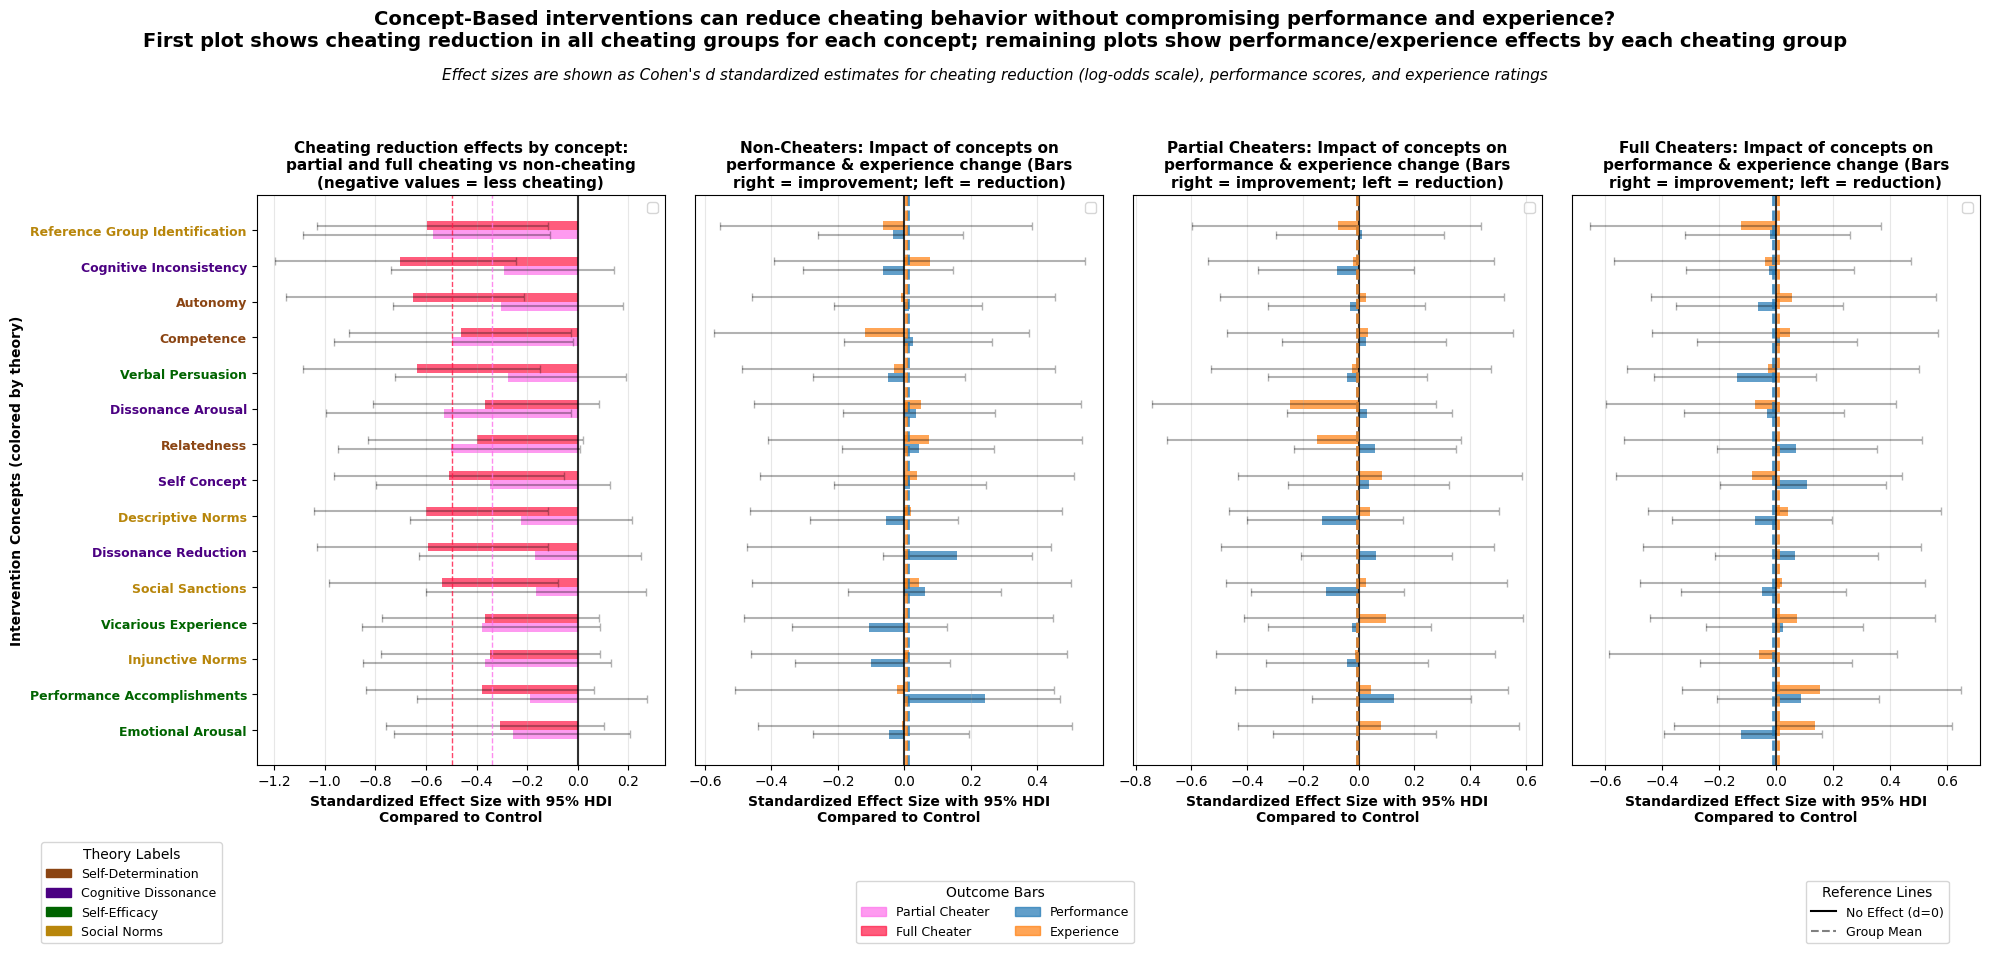

In [15]:
# ===============================================================================================================================
# RQ1: VISUALIZATION OF CHANGES IN CHEATING BEHAVIOR, PERFORMANCE and EXPERIENCE BY ALL CONCEPTS VARIED OVER DIFFERENT CHEATING GROUPS
# ===============================================================================================================================

# Reverse ordering for visualization (least effective at top, most effective at bottom)
concepts_ordered_viz = list(reversed(concepts_ordered))

# Define colors
cheating_colors = ['#FE70EB', '#FF1745']  # Magenta for partial, Red for full
perf_exp_colors = ['#1f77b4', '#ff7f0e']  # Blue for performance, orange for experience

# Theory colors (unchanged)
theory_colors = {
    "autonomy": "#8B4513", "competence": "#8B4513", "relatedness": "#8B4513",
    "self_concept": "#4B0082", "cognitive_inconsistency": "#4B0082",
    "dissonance_arousal": "#4B0082", "dissonance_reduction": "#4B0082",
    "performance_accomplishments": "#006400", "vicarious_experience": "#006400",
    "verbal_persuasion": "#006400", "emotional_arousal": "#006400",
    "descriptive_norms": "#B8860B", "injunctive_norms": "#B8860B",
    "social_sanctions": "#B8860B", "reference_group_identification": "#B8860B"
}

# Prepare data for visualization
def prepare_viz_data():
    """Extract effect sizes and HDIs for visualization"""
    
    # Cheating behavior effects - CORRECTED
    partial_d = [cheating_effects[concept]['partial_d'] for concept in concepts_ordered_viz]
    full_d = [cheating_effects[concept]['full_d'] for concept in concepts_ordered_viz]
    
    partial_hdi = [cheating_effects[concept]['partial_hdi'] for concept in concepts_ordered_viz]
    full_hdi = [cheating_effects[concept]['full_hdi'] for concept in concepts_ordered_viz]
    
    # Performance effects by group
    perf_non = [performance_effects[concept]['non_cheater_d'] for concept in concepts_ordered_viz]
    perf_partial = [performance_effects[concept]['partial_cheater_d'] for concept in concepts_ordered_viz]
    perf_full = [performance_effects[concept]['full_cheater_d'] for concept in concepts_ordered_viz]
    
    perf_non_hdi = [performance_effects[concept]['non_cheater_hdi'] for concept in concepts_ordered_viz]
    perf_partial_hdi = [performance_effects[concept]['partial_cheater_hdi'] for concept in concepts_ordered_viz]
    perf_full_hdi = [performance_effects[concept]['full_cheater_hdi'] for concept in concepts_ordered_viz]
    
    # Experience effects by group
    exp_non = [experience_effects[concept]['non_cheater_d'] for concept in concepts_ordered_viz]
    exp_partial = [experience_effects[concept]['partial_cheater_d'] for concept in concepts_ordered_viz]
    exp_full = [experience_effects[concept]['full_cheater_d'] for concept in concepts_ordered_viz]
    
    exp_non_hdi = [experience_effects[concept]['non_cheater_hdi'] for concept in concepts_ordered_viz]
    exp_partial_hdi = [experience_effects[concept]['partial_cheater_hdi'] for concept in concepts_ordered_viz]
    exp_full_hdi = [experience_effects[concept]['full_cheater_hdi'] for concept in concepts_ordered_viz]
    
    # Calculate error bars
    def calc_err(values, hdis):
        return [[v - h[0] for v, h in zip(values, hdis)], [h[1] - v for v, h in zip(values, hdis)]]
    
    return {
        'cheating': {
            'partial': partial_d, 
            'full': full_d,
            'partial_err': calc_err(partial_d, partial_hdi),
            'full_err': calc_err(full_d, full_hdi),
            'means': [np.mean(partial_d), np.mean(full_d)]
        },
        'performance': {
            'non': perf_non, 'partial': perf_partial, 'full': perf_full,
            'non_err': calc_err(perf_non, perf_non_hdi),
            'partial_err': calc_err(perf_partial, perf_partial_hdi),
            'full_err': calc_err(perf_full, perf_full_hdi),
            'means': [np.mean(perf_non), np.mean(perf_partial), np.mean(perf_full)]
        },
        'experience': {
            'non': exp_non, 'partial': exp_partial, 'full': exp_full,
            'non_err': calc_err(exp_non, exp_non_hdi),
            'partial_err': calc_err(exp_partial, exp_partial_hdi),
            'full_err': calc_err(exp_full, exp_full_hdi),
            'means': [np.mean(exp_non), np.mean(exp_partial), np.mean(exp_full)]
        }
    }

# Prepare data
data = prepare_viz_data()
y_pos = range(len(concepts_ordered_viz))
width = 0.25

# Create 1x4 grid visualization
fig, axes = plt.subplots(1, 4, figsize=(20, 10))

# Plot 1: Cheating behavior changes
ax1 = axes[0]
ax1.barh([y - width/2 for y in y_pos], data['cheating']['partial'], width, 
         xerr=data['cheating']['partial_err'], capsize=3, error_kw={'alpha': 0.3},
         color=cheating_colors[0], alpha=0.7)
ax1.barh([y + width/2 for y in y_pos], data['cheating']['full'], width,
         xerr=data['cheating']['full_err'], capsize=3, error_kw={'alpha': 0.3},
         color=cheating_colors[1], alpha=0.7)

ax1.axvline(0, color='black', linestyle='-', alpha=0.8, linewidth=1.5)
for i, mean in enumerate(data['cheating']['means']):
    ax1.axvline(mean, color=cheating_colors[i], linestyle='--', alpha=0.8, linewidth=1)

# ax1.set_title('Impact of concepts on cheating behavior change for\npartial and full cheaters from non-cheaters: bars\nfurther left or right = stronger cheating reduction', fontweight='bold', fontsize=11)
ax1.set_title('Cheating reduction effects by concept:\npartial and full cheating vs non-cheating\n(negative values = less cheating)', fontweight='bold', fontsize=11)
ax1.set_xlabel('Standardized Effect Size with 95% HDI\nCompared to Control', fontweight='bold', fontsize=10)
ax1.set_ylabel('Intervention Concepts (colored by theory)', fontweight='bold', fontsize=10)
ax1.set_yticks(y_pos)
ax1.set_yticklabels([c.replace('_', ' ').title() for c in concepts_ordered_viz], fontsize=9)
ax1.grid(axis='x', alpha=0.3)
ax1.legend()

# Add theory color coding to y-labels
for i, concept in enumerate(concepts_ordered_viz):
    label_color = theory_colors.get(concept, 'black')
    ax1.get_yticklabels()[i].set_color(label_color)
    ax1.get_yticklabels()[i].set_fontweight('bold')

# Function for performance/experience plots
def plot_group_outcome(ax, outcome_type, group_name, group_label):
    group_data = data[outcome_type]
    
    perf_values = group_data[group_name]
    exp_values = data['experience'][group_name]
    
    ax.barh([y - width/2 for y in y_pos], perf_values, width,
           xerr=group_data[f'{group_name}_err'], capsize=3, error_kw={'alpha': 0.3},
           color=perf_exp_colors[0], alpha=0.7)
    ax.barh([y + width/2 for y in y_pos], exp_values, width,
           xerr=data['experience'][f'{group_name}_err'], capsize=3, error_kw={'alpha': 0.3},
            color=perf_exp_colors[1], alpha=0.7)
    
    ax.axvline(0, color='black', linestyle='-', alpha=0.8, linewidth=1.5)
    ax.axvline(data['performance']['means'][['non', 'partial', 'full'].index(group_name)], 
               color=perf_exp_colors[0], linestyle='--', alpha=0.8, linewidth=2)
    ax.axvline(data['experience']['means'][['non', 'partial', 'full'].index(group_name)], 
               color=perf_exp_colors[1], linestyle='--', alpha=0.8, linewidth=2)
    
    ax.set_title(f'{group_label}: Impact of concepts on\nperformance & experience change (Bars\nright = improvement; left = reduction)', fontweight='bold', fontsize=11)
    ax.set_xlabel('Standardized Effect Size with 95% HDI\nCompared to Control', fontweight='bold', fontsize=10)
    ax.set_yticks([])
    ax.grid(axis='x', alpha=0.3)
    ax.legend()

# Plots 2-4: Performance and Experience effects for each group
group_specs = [('non', 'Non-Cheaters'), ('partial', 'Partial Cheaters'), ('full', 'Full Cheaters')]
for i, (group_name, group_label) in enumerate(group_specs):
    plot_group_outcome(axes[i+1], 'performance', group_name, group_label)

# Create legends
theory_legend = [plt.Rectangle((0,0), 1, 1, color=color, label=theory) 
                for theory, color in [('Self-Determination', '#8B4513'), ('Cognitive Dissonance', '#4B0082'),
                                     ('Self-Efficacy', '#006400'), ('Social Norms', '#B8860B')]]

outcome_legend = [plt.Rectangle((0,0), 1, 1, color=color, alpha=0.7, label=label) 
                 for color, label in [(cheating_colors[0], 'Partial Cheater'), (cheating_colors[1], 'Full Cheater'),
                                     (perf_exp_colors[0], 'Performance'), (perf_exp_colors[1], 'Experience')]]

reference_legend = [plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label='No Effect (d=0)'),
                   plt.Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5, label='Group Mean')]

# Add legends
fig.legend(handles=theory_legend, loc='lower left', bbox_to_anchor=(0.02, 0.01), 
          title='Theory Labels', fontsize=9, title_fontsize=10)
fig.legend(handles=outcome_legend, loc='lower center', bbox_to_anchor=(0.5, 0.01), 
          title='Outcome Bars', fontsize=9, title_fontsize=10, ncol=2)
fig.legend(handles=reference_legend, loc='lower right', bbox_to_anchor=(0.98, 0.01), 
          title='Reference Lines', fontsize=9, title_fontsize=10)

plt.suptitle('Concept-Based interventions can reduce cheating behavior without compromising performance and experience?\nFirst plot shows cheating reduction in all cheating groups for each concept; remaining plots show performance/experience effects by each cheating group', 
             fontsize=14, fontweight='bold', y=0.95)
plt.figtext(0.5, 0.88, 'Effect sizes are shown as Cohen\'s d standardized estimates for cheating reduction (log-odds scale), performance scores, and experience ratings', 
           ha='center', fontsize=11, style='italic')
plt.tight_layout(rect=[0, 0.12, 1, 0.89])
plt.show()


## Concepts → Mediators → Outcomes

### Mediation Analysis: Concept → Mediators → Performance/Experience for Cheating Groups

In [18]:
# ============================================================================
# MODEL 3: MEDIATION ANALYSIS FOR RQ3
#
# MODEL 3A: CONCEPTS → MEDIATORS (PATH A) - GROUP-SPECIFIC
#
# For each mediator m ∈ {ability, honesty, discomfort}:
# Mediator_m = β₀_m[cheating_cat] + Σ(β_i_m[cheating_cat] × ConceptDummy_i) + message_effects_m + ε_m
#
# Where:
# - β₀_m[cheating_cat]: Baseline mediator levels by cheating category (non-cheater, partial, full)
# - β_i_m[cheating_cat]: Concept effects on mediator m, varying by cheating category
# - message_effects_m: Random effects for motivational message variations
# - ε_m: Residual error for mediator m
#
# MODEL 3B: MEDIATORS + CONCEPTS → OUTCOMES BY GROUP (PATH B + C')
#
# Performance = β₀_perf[cheating_cat] + Σ(β_j_perf[cheating_cat] × Mediator_j) 
#             + Σ(β_i_perf[cheating_cat] × ConceptDummy_i) + ε_perf
#
# Experience = β₀_exp[cheating_cat] + Σ(β_j_exp[cheating_cat] × Mediator_j) 
#            + Σ(β_i_exp[cheating_cat] × ConceptDummy_i) + ε_exp
#
# Where:
# - β₀[cheating_cat]: Control baseline by cheating category
# - β_j[cheating_cat]: Effects of mediator j on outcome, varying by cheating category (PATH B)
# - β_i[cheating_cat]: Direct concept effects on outcome, varying by cheating category (PATH C')
# - Mediator_j ∈ {ability, honesty, discomfort}: Standardized mediator variables
#
# INDIRECT EFFECTS CALCULATION:
# Indirect Effect = PATH A × PATH B
# For concept i affecting outcome via mediator j in group g:
# IE_ijg = β_i_j[g] × β_j_outcome[g]
#
# Total Indirect Effect for concept i on outcome in group g:
# Total_IE_ig = Σ_j (β_i_j[g] × β_j_outcome[g])
# ============================================================================

# Prepare mediator variables (standardized)
mediators = {
    'ability': (df['word_creation_skill_level'] - df['word_creation_skill_level'].mean()) / df['word_creation_skill_level'].std(),
    'honesty': -(df['moral_disengagement'] - df['moral_disengagement'].mean()) / df['moral_disengagement'].std(),
    'discomfort': (df['cognitive_discomfort'] - df['cognitive_discomfort'].mean()) / df['cognitive_discomfort'].std()
}

# MODEL 3A: Concepts → Mediators (PATH A) - GROUP-SPECIFIC
with pm.Model() as mediator_model:
    for med_name, med_values in mediators.items():
        # Group-specific baselines
        baseline = pm.Normal(f'{med_name}_baseline', mu=0, sigma=0.5, shape=3)
        
        # Group-specific concept effects: [concept, group]
        concept_effects = pm.Normal(f'{med_name}_concept_effects', mu=0, sigma=0.3, shape=(len(concepts), 3))
        
        # Message effects (same across groups)
        message_effects = pm.Normal(f'{med_name}_message_effects', mu=0, sigma=0.2, shape=len(message_ids.cat.categories))
        
        # Linear predictor with group-specific effects
        mu = baseline[y_cheating_behavior] + message_effects[message_codes]
        mu += pm.math.switch(concept_codes > 0, 
                            concept_effects[concept_codes - 1, y_cheating_behavior], 0)
        
        pm.Normal(f'{med_name}_obs', mu=mu, sigma=pm.HalfNormal(f'{med_name}_sigma', sigma=0.5), 
                 observed=med_values)

# MODEL 3B: Mediators + Concepts → Outcomes by Group (PATH B + C')
with pm.Model() as outcome_model:
    mediator_matrix = np.column_stack([mediators['ability'], mediators['honesty'], mediators['discomfort']])
    
    # Performance
    perf_baseline = pm.Normal('perf_baseline', mu=control_means_perf, sigma=2.0, shape=3)
    perf_mediator_effects = pm.Normal('perf_mediator_effects', mu=0, sigma=1.0, shape=(3, 3))  # [mediator, group]
    perf_concept_direct = pm.Normal('perf_concept_direct', mu=0, sigma=1.5, shape=(len(concepts), 3))  # [concept, group]
    
    mu_perf = perf_baseline[y_cheating_behavior]
    for med_idx in range(3):
        mu_perf += mediator_matrix[:, med_idx] * perf_mediator_effects[med_idx, y_cheating_behavior]
    mu_perf += pm.math.switch(concept_codes > 0, perf_concept_direct[concept_codes - 1, y_cheating_behavior], 0)
    
    # Experience
    exp_baseline = pm.Normal('exp_baseline', mu=control_means_exp, sigma=0.3, shape=3)
    exp_mediator_effects = pm.Normal('exp_mediator_effects', mu=0, sigma=0.3, shape=(3, 3))
    exp_concept_direct = pm.Normal('exp_concept_direct', mu=0, sigma=0.3, shape=(len(concepts), 3))
    
    mu_exp = exp_baseline[y_cheating_behavior]
    for med_idx in range(3):
        mu_exp += mediator_matrix[:, med_idx] * exp_mediator_effects[med_idx, y_cheating_behavior]
    mu_exp += pm.math.switch(concept_codes > 0, exp_concept_direct[concept_codes - 1, y_cheating_behavior], 0)
    
    # Likelihoods
    pm.Normal('performance_mediated', mu=mu_perf, sigma=pm.HalfNormal('perf_sigma_med', sigma=5.0), observed=y_performance)
    pm.Normal('experience_mediated', mu=mu_exp, sigma=pm.HalfNormal('exp_sigma_med', sigma=0.5), observed=y_experience)

# Fit models
print("Fitting mediation models...")
with mediator_model:
    trace_mediators = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)

with outcome_model:
    trace_outcomes = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)

print("Models fitted successfully!")



Fitting mediation models...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ability_baseline, ability_concept_effects, ability_message_effects, ability_sigma, honesty_baseline, honesty_concept_effects, honesty_message_effects, honesty_sigma, discomfort_baseline, discomfort_concept_effects, discomfort_message_effects, discomfort_sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 18 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [perf_baseline, perf_mediator_effects, perf_concept_direct, exp_baseline, exp_mediator_effects, exp_concept_direct, perf_sigma_med, exp_sigma_med]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 30 seconds.


Models fitted successfully!


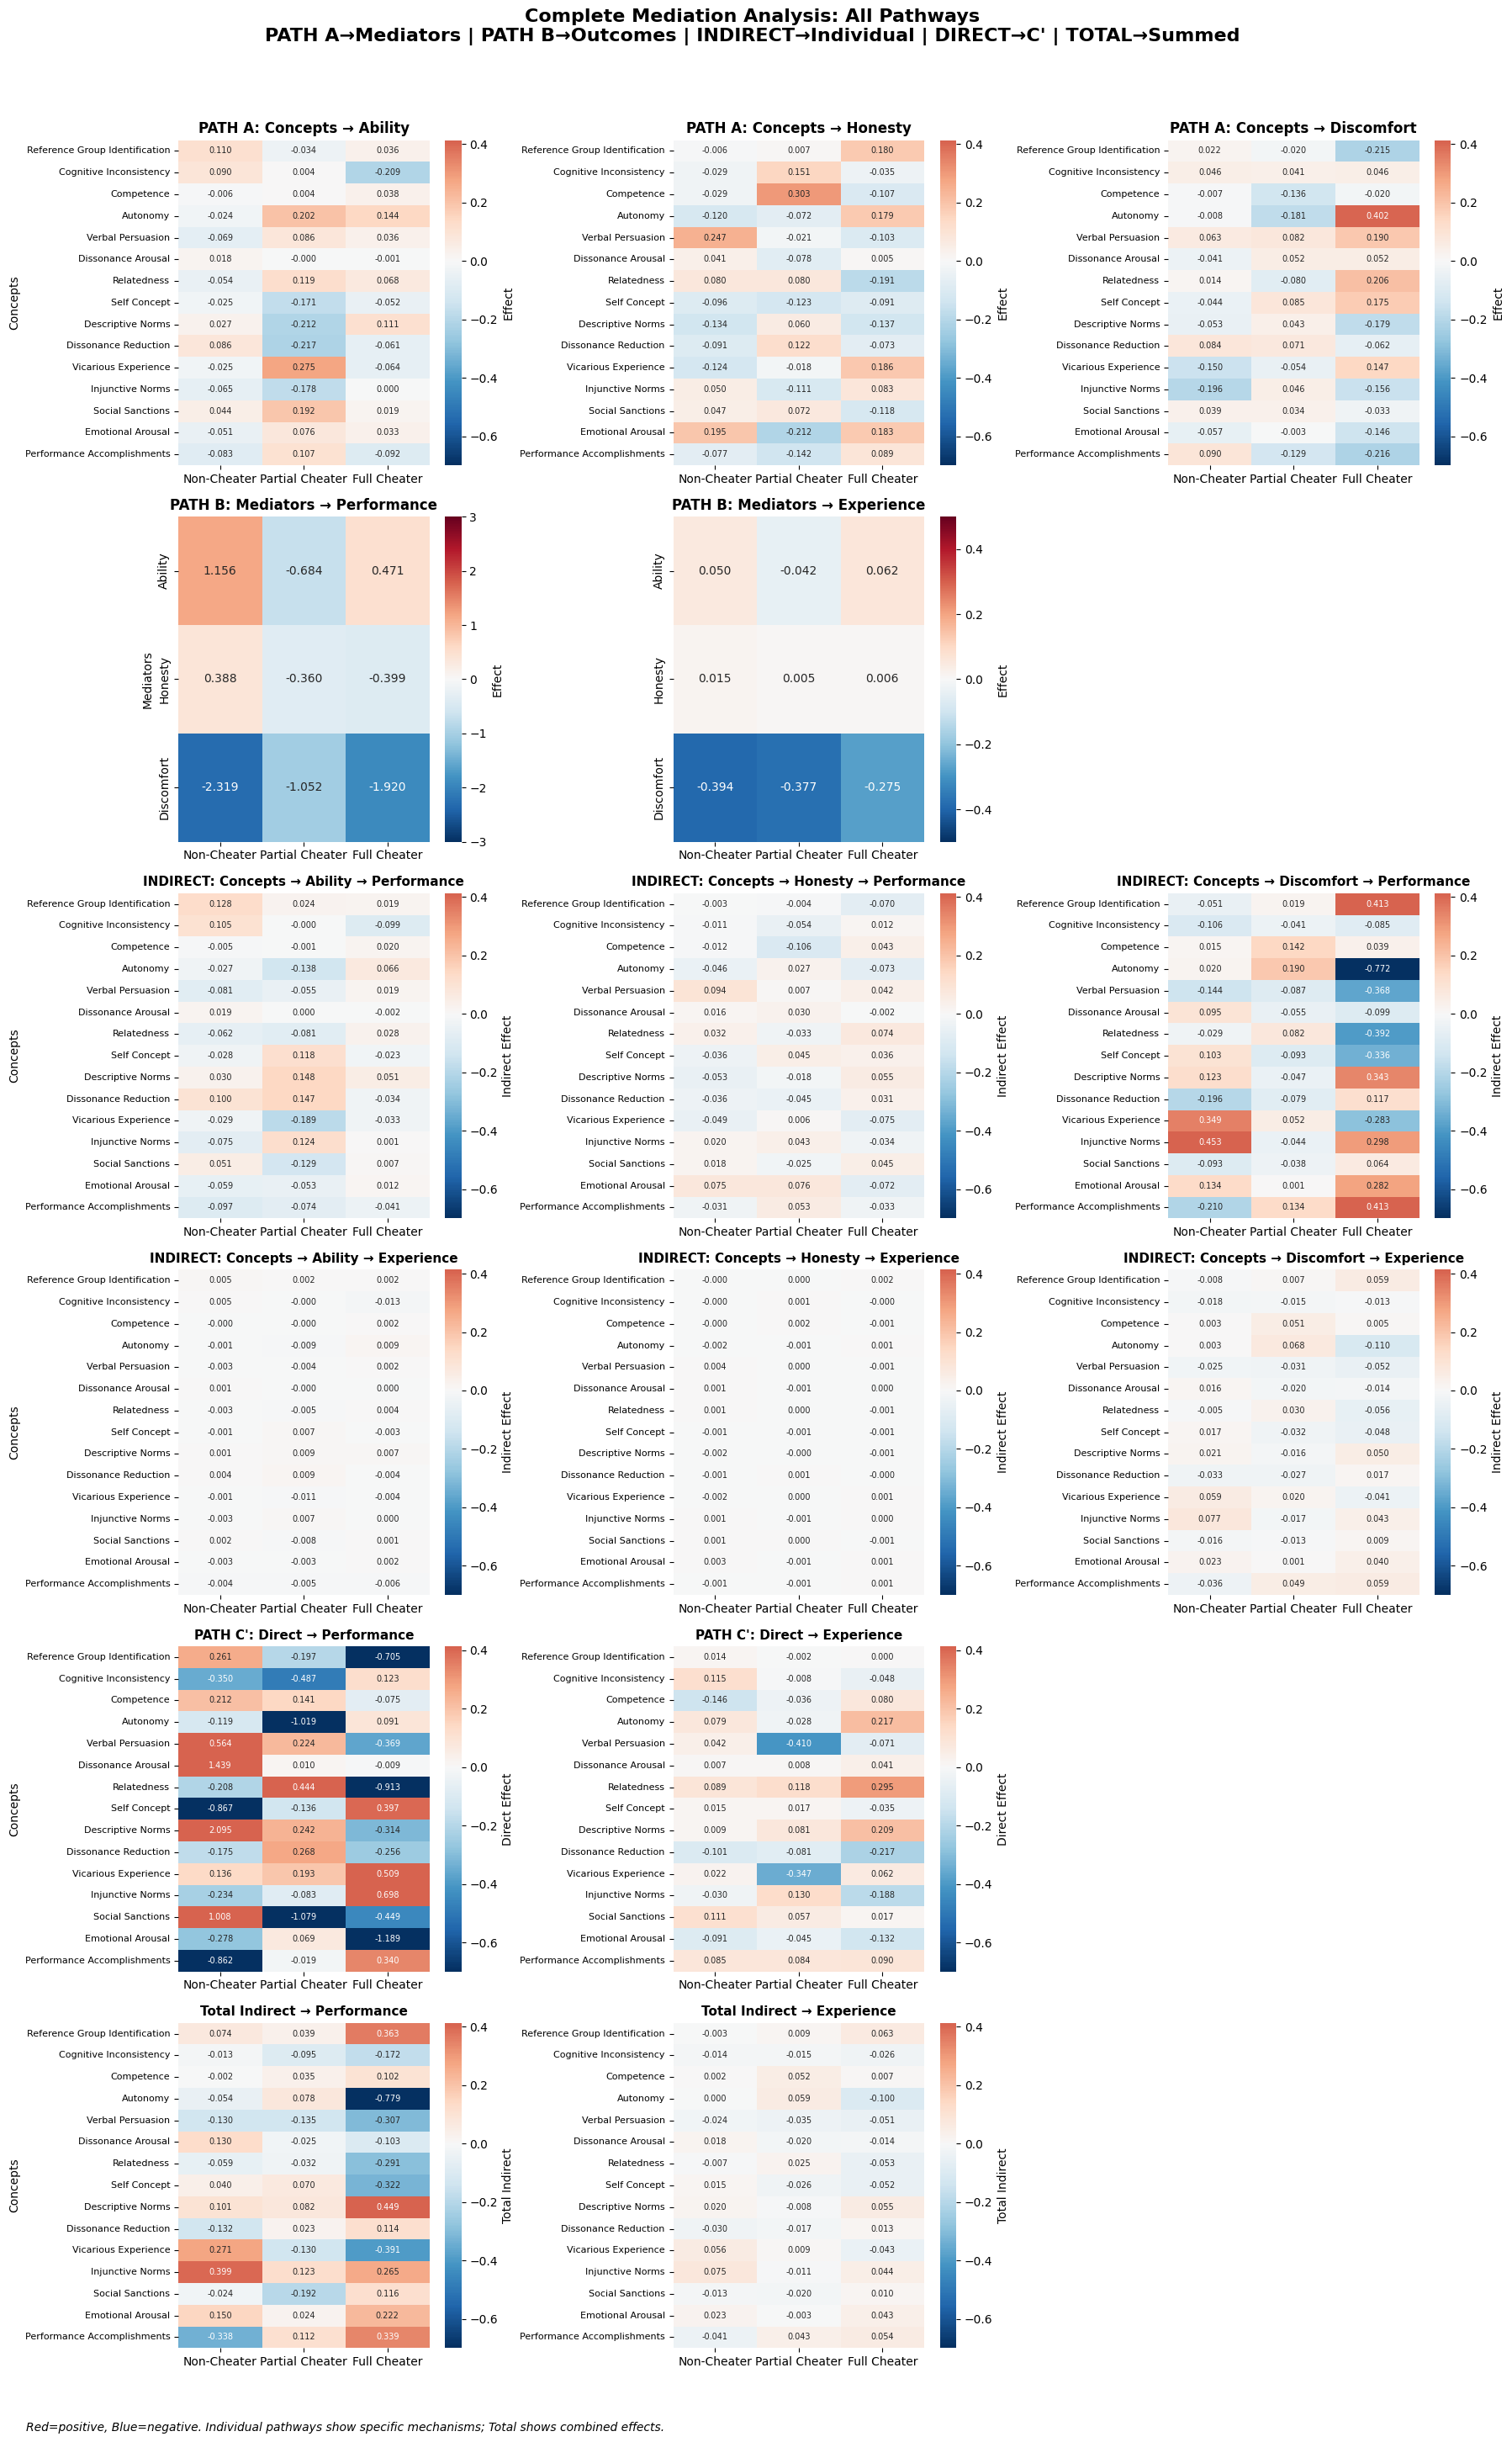

In [23]:
# ============================================================================
# COMPLETE MEDIATION ANALYSIS HEATMAP VISUALIZATION
# ============================================================================

def calculate_all_mediation_effects():
    """Calculate all mediation pathway effects"""
    # Extract posterior samples
    ability_effects = trace_mediators.posterior['ability_concept_effects'].values.reshape(-1, len(concepts), 3)
    honesty_effects = trace_mediators.posterior['honesty_concept_effects'].values.reshape(-1, len(concepts), 3)
    discomfort_effects = trace_mediators.posterior['discomfort_concept_effects'].values.reshape(-1, len(concepts), 3)
    
    perf_med_samples = trace_outcomes.posterior['perf_mediator_effects'].values.reshape(-1, 3, 3)
    exp_med_samples = trace_outcomes.posterior['exp_mediator_effects'].values.reshape(-1, 3, 3)
    
    # Individual indirect effects (Path A × Path B)
    pathways = {}
    mediator_samples = [ability_effects, honesty_effects, discomfort_effects]
    mediator_names = ['ability', 'honesty', 'discomfort']
    
    for i, (med_name, med_samples) in enumerate(zip(mediator_names, mediator_samples)):
        pathways[f'{med_name}_to_perf'] = np.array([[
            (med_samples[:, c, g] * perf_med_samples[:, i, g]).mean() 
            for g in range(3)] for c in range(len(concepts))])
        pathways[f'{med_name}_to_exp'] = np.array([[
            (med_samples[:, c, g] * exp_med_samples[:, i, g]).mean() 
            for g in range(3)] for c in range(len(concepts))])
    
    return pathways

# Calculate effects
individual_pathways = calculate_all_mediation_effects()

# Data preparation
mediator_names = ['ability', 'honesty', 'discomfort']
cheating_groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
concept_labels = [c.replace('_', ' ').title() for c in concepts_ordered_mediation]

# Consistent color scaling
all_effects = np.concatenate([
    np.array(list(path_a_effects.values())).flatten(),
    path_b_performance.flatten(), path_b_experience.flatten(),
    np.array(list(individual_pathways.values())).flatten(),
    path_c_performance.flatten(), path_c_experience.flatten()
])
vmin, vmax = np.percentile(all_effects, [2, 98])

# Create 6x3 grid
fig, axes = plt.subplots(6, 3, figsize=(18, 30))

# ROW 1: PATH A (Concepts → Mediators)
for i, med_name in enumerate(mediator_names):
    sns.heatmap(path_a_effects[med_name], xticklabels=cheating_groups, yticklabels=concept_labels,
                cmap='RdBu_r', center=0, vmin=vmin, vmax=vmax, annot=True, fmt='.3f', 
                annot_kws={'size': 7}, cbar_kws={'label': 'Effect'}, ax=axes[0, i])
    axes[0, i].set_title(f'PATH A: Concepts → {med_name.title()}', fontweight='bold')
    axes[0, i].set_ylabel('Concepts' if i == 0 else '')
    axes[0, i].set_yticklabels(axes[0, i].get_yticklabels(), rotation=0, fontsize=8)

# ROW 2: PATH B (Mediators → Performance)
sns.heatmap(path_b_performance, xticklabels=cheating_groups, yticklabels=[m.title() for m in mediator_names],
            cmap='RdBu_r', center=0, vmin=-3, vmax=3, annot=True, fmt='.3f',
            cbar_kws={'label': 'Effect'}, ax=axes[1, 0])
axes[1, 0].set_title('PATH B: Mediators → Performance', fontweight='bold')
axes[1, 0].set_ylabel('Mediators')

# ROW 2: PATH B (Mediators → Experience)  
sns.heatmap(path_b_experience, xticklabels=cheating_groups, yticklabels=[m.title() for m in mediator_names],
            cmap='RdBu_r', center=0, vmin=-0.5, vmax=0.5, annot=True, fmt='.3f',
            cbar_kws={'label': 'Effect'}, ax=axes[1, 1])
axes[1, 1].set_title('PATH B: Mediators → Experience', fontweight='bold')
axes[1, 2].axis('off')

# ROWS 3-4: INDIRECT EFFECTS (Individual Pathways)
pathway_configs = [
    ('ability_to_perf', 'Ability → Performance', 2, 0),
    ('honesty_to_perf', 'Honesty → Performance', 2, 1),
    ('discomfort_to_perf', 'Discomfort → Performance', 2, 2),
    ('ability_to_exp', 'Ability → Experience', 3, 0),
    ('honesty_to_exp', 'Honesty → Experience', 3, 1),
    ('discomfort_to_exp', 'Discomfort → Experience', 3, 2)
]

for pathway_key, title, row, col in pathway_configs:
    sns.heatmap(individual_pathways[pathway_key], xticklabels=cheating_groups, yticklabels=concept_labels,
                cmap='RdBu_r', center=0, vmin=vmin, vmax=vmax, annot=True, fmt='.3f',
                annot_kws={'size': 7}, cbar_kws={'label': 'Indirect Effect'}, ax=axes[row, col])
    axes[row, col].set_title(f'INDIRECT: Concepts → {title}', fontweight='bold', fontsize=11)
    axes[row, col].set_ylabel('Concepts' if col == 0 else '')
    axes[row, col].set_yticklabels(axes[row, col].get_yticklabels(), rotation=0, fontsize=8)

# ROW 5: PATH C' (Direct Effects)
direct_configs = [
    (path_c_performance, 'Direct → Performance', 4, 0),
    (path_c_experience, 'Direct → Experience', 4, 1)
]

for data, title, row, col in direct_configs:
    sns.heatmap(data, xticklabels=cheating_groups, yticklabels=concept_labels,
                cmap='RdBu_r', center=0, vmin=vmin, vmax=vmax, annot=True, fmt='.3f',
                annot_kws={'size': 7}, cbar_kws={'label': 'Direct Effect'}, ax=axes[row, col])
    axes[row, col].set_title(f'PATH C\': {title}', fontweight='bold', fontsize=11)
    axes[row, col].set_ylabel('Concepts' if col == 0 else '')
    axes[row, col].set_yticklabels(axes[row, col].get_yticklabels(), rotation=0, fontsize=8)
axes[4, 2].axis('off')

# ROW 6: TOTAL INDIRECT EFFECTS (sum across mediators)
total_indirect_perf = sum(individual_pathways[f'{med}_to_perf'] for med in mediator_names)
total_indirect_exp = sum(individual_pathways[f'{med}_to_exp'] for med in mediator_names)

total_configs = [
    (total_indirect_perf, 'Total Indirect → Performance', 5, 0),
    (total_indirect_exp, 'Total Indirect → Experience', 5, 1)
]

for data, title, row, col in total_configs:
    sns.heatmap(data, xticklabels=cheating_groups, yticklabels=concept_labels,
                cmap='RdBu_r', center=0, vmin=vmin, vmax=vmax, annot=True, fmt='.3f',
                annot_kws={'size': 7}, cbar_kws={'label': 'Total Indirect'}, ax=axes[row, col])
    axes[row, col].set_title(title, fontweight='bold', fontsize=11)
    axes[row, col].set_ylabel('Concepts' if col == 0 else '')
    axes[row, col].set_yticklabels(axes[row, col].get_yticklabels(), rotation=0, fontsize=8)
axes[5, 2].axis('off')

# Styling
plt.suptitle('Complete Mediation Analysis: All Pathways\nPATH A→Mediators | PATH B→Outcomes | INDIRECT→Individual | DIRECT→C\' | TOTAL→Summed',
             fontsize=16, fontweight='bold', y=0.98)
fig.text(0.02, 0.02, 'Red=positive, Blue=negative. Individual pathways show specific mechanisms; Total shows combined effects.',
         fontsize=10, style='italic')
plt.tight_layout(rect=[0, 0.04, 1, 0.96])
plt.show()


In [22]:
# ============================================================================
# CONCISE SUMMARY STATISTICS FOR MEDIATION EFFECTS
# ============================================================================

def print_mediation_summary():
    """Print concise mediation analysis summary with all pathways"""
    
    print("="*80)
    print("MEDIATION ANALYSIS SUMMARY")
    print("="*80)
    
    # PATH A: Concepts → Mediators
    print("\nPATH A: CONCEPTS → MEDIATORS")
    print("-" * 40)
    for med_name in mediator_names:
        print(f"\n{med_name.upper()}:")
        df = pd.DataFrame(path_a_effects[med_name], index=concept_labels, columns=cheating_groups)
        print(df.round(3).to_string())
    
    # PATH B: Mediators → Outcomes
    print("\n\nPATH B: MEDIATORS → OUTCOMES")
    print("-" * 40)
    print("\nPERFORMANCE:")
    print(pd.DataFrame(path_b_performance, index=[m.title() for m in mediator_names], columns=cheating_groups).round(3).to_string())
    print("\nEXPERIENCE:")
    print(pd.DataFrame(path_b_experience, index=[m.title() for m in mediator_names], columns=cheating_groups).round(3).to_string())
    
    # Individual Indirect Effects
    print("\n\nINDIVIDUAL INDIRECT PATHWAYS")
    print("-" * 40)
    pathway_names = [
        ('Ability → Performance', 'ability_to_perf'),
        ('Honesty → Performance', 'honesty_to_perf'), 
        ('Discomfort → Performance', 'discomfort_to_perf'),
        ('Ability → Experience', 'ability_to_exp'),
        ('Honesty → Experience', 'honesty_to_exp'),
        ('Discomfort → Experience', 'discomfort_to_exp')
    ]
    
    for name, key in pathway_names:
        print(f"\n{name}:")
        df = pd.DataFrame(individual_pathways[key], index=concept_labels, columns=cheating_groups)
        print(df.round(3).to_string())
    
    # Total Indirect Effects
    print("\n\nTOTAL INDIRECT EFFECTS (Sum across mediators)")
    print("-" * 50)
    print("\nPERFORMANCE:")
    total_perf = sum(individual_pathways[f'{med}_to_perf'] for med in mediator_names)
    print(pd.DataFrame(total_perf, index=concept_labels, columns=cheating_groups).round(3).to_string())
    
    print("\nEXPERIENCE:")
    total_exp = sum(individual_pathways[f'{med}_to_exp'] for med in mediator_names)
    print(pd.DataFrame(total_exp, index=concept_labels, columns=cheating_groups).round(3).to_string())
    
    # Direct Effects (PATH C')
    print("\n\nPATH C': DIRECT EFFECTS")
    print("-" * 30)
    print("\nPERFORMANCE:")
    print(pd.DataFrame(path_c_performance, index=concept_labels, columns=cheating_groups).round(3).to_string())
    print("\nEXPERIENCE:")
    print(pd.DataFrame(path_c_experience, index=concept_labels, columns=cheating_groups).round(3).to_string())
    
    # Top effects summary
    print("\n\nTOP 10 STRONGEST INDIVIDUAL PATHWAYS")
    print("-" * 45)
    all_pathways = []
    for name, key in pathway_names:
        data = individual_pathways[key]
        for i, concept in enumerate(concept_labels):
            for j, group in enumerate(cheating_groups):
                all_pathways.append((abs(data[i,j]), f"{concept} → {name} ({group})", data[i,j]))
    
    all_pathways.sort(reverse=True)
    print(f"{'Pathway':50} {'Effect':>8}")
    print("-" * 60)
    for _, pathway, effect in all_pathways[:10]:
        print(f"{pathway:50} {effect:8.3f}")

# Run summary
print_mediation_summary()

MEDIATION ANALYSIS SUMMARY

PATH A: CONCEPTS → MEDIATORS
----------------------------------------

ABILITY:
                                Non-Cheater  Partial Cheater  Full Cheater
Reference Group Identification        0.110           -0.034         0.036
Cognitive Inconsistency               0.090            0.004        -0.209
Competence                           -0.006            0.004         0.038
Autonomy                             -0.024            0.202         0.144
Verbal Persuasion                    -0.069            0.086         0.036
Dissonance Arousal                    0.018           -0.000        -0.001
Relatedness                          -0.054            0.119         0.068
Self Concept                         -0.025           -0.171        -0.052
Descriptive Norms                     0.027           -0.212         0.111
Dissonance Reduction                  0.086           -0.217        -0.061
Vicarious Experience                 -0.025            0.275       

## Concepts → Message Processing → Mediators → Outcomes

#### Message induced or task induced discomfort?

Processing comprehension...
  1159 valid responses (skipping 42 nulls)
  Batch 1/58 completed
  Batch 2/58 completed
  Batch 3/58 completed
  Batch 4/58 completed
  Batch 5/58 completed
  Batch 6/58 completed
  Batch 7/58 completed
  Batch 8/58 completed
  Batch 9/58 completed
  Batch 10/58 completed
  Batch 11/58 completed
  Batch 12/58 completed
  Batch 13/58 completed
  Batch 14/58 completed
  Batch 15/58 completed
  Batch 16/58 completed
  Batch 17/58 completed
  Batch 18/58 completed
  Batch 19/58 completed
  Batch 20/58 completed
  Batch 21/58 completed
  Batch 22/58 completed
  Batch 23/58 completed
  Batch 24/58 completed
  Batch 25/58 completed
  Batch 26/58 completed
  Batch 27/58 completed
  Batch 28/58 completed
  Batch 29/58 completed
  Batch 30/58 completed
  Batch 31/58 completed
  Batch 32/58 completed
  Batch 33/58 completed
  Batch 34/58 completed
  Batch 35/58 completed
  Batch 36/58 completed
  Batch 37/58 completed
  Batch 38/58 completed
  Batch 39/58 completed
  

/var/folders/9x/l7cjx6vd0518z9mfnzrvbtt97pcxk7/T/ipykernel_69234/2289397679.py:404: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(concept_data, labels=[label[:15] for label in concept_labels])
/var/folders/9x/l7cjx6vd0518z9mfnzrvbtt97pcxk7/T/ipykernel_69234/2289397679.py:404: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(concept_data, labels=[label[:15] for label in concept_labels])
/var/folders/9x/l7cjx6vd0518z9mfnzrvbtt97pcxk7/T/ipykernel_69234/2289397679.py:404: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(concept_data, labels=[label[:15] for label in concept_labels])


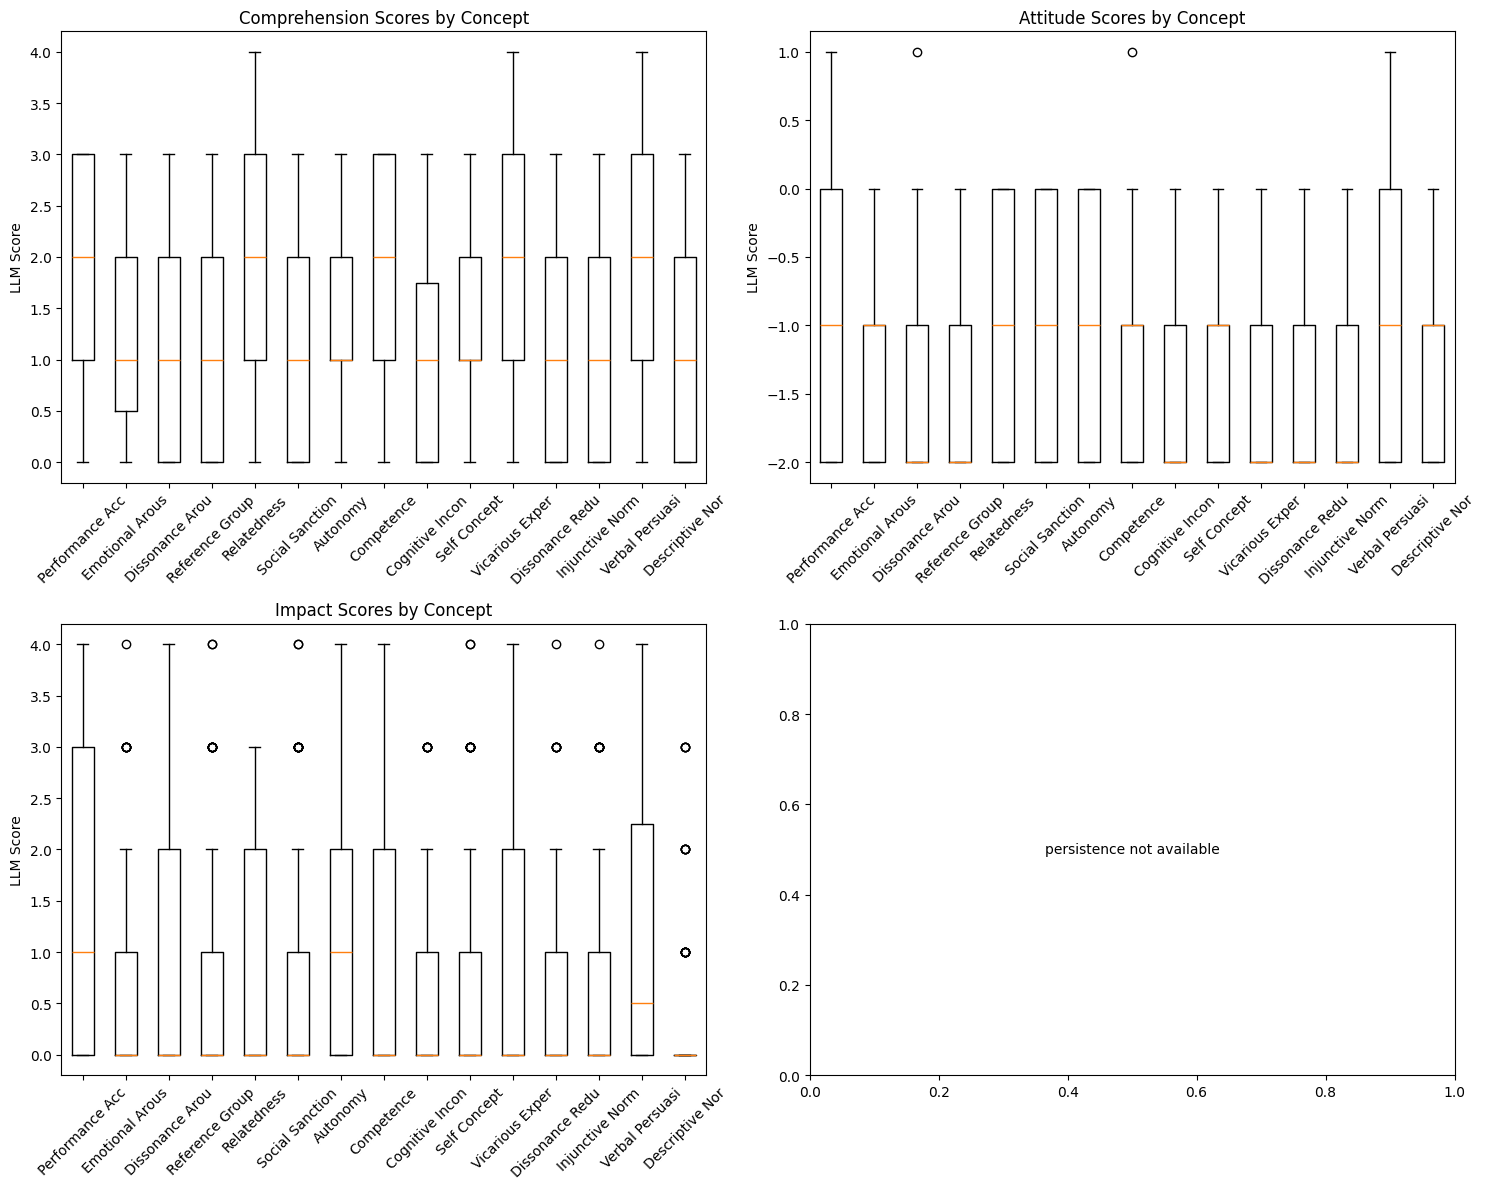

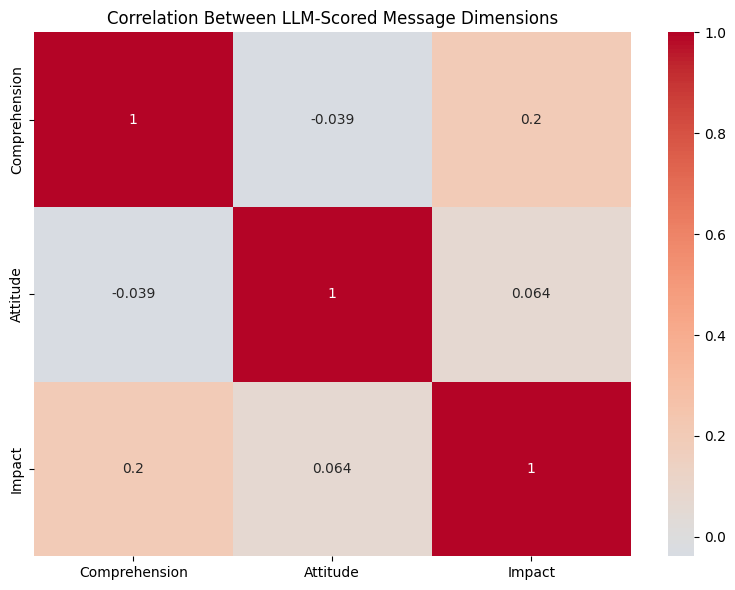

In [34]:
# ============================================================================
# LLM-BASED MESSAGE PROCESSING ANALYSIS
# ============================================================================

import pandas as pd
import numpy as np
from openai import OpenAI
from dotenv import load_dotenv
import os
import time
import json
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

# Load environment variables and initialize OpenAI client
load_dotenv()
client = OpenAI()

# ============================================================================
# 1. CONCEPT DEFINITIONS FOR LLM SCORING
# ============================================================================

CONCEPT_DEFINITIONS = {
    'autonomy': "The need to feel volitional and self-directed in one's actions, having choice and control over decisions.",
    'competence': "The need to feel effective and capable of achieving desired outcomes and mastering challenges.",
    'relatedness': "The need to feel connected to others and experience a sense of belonging and attachment.",
    'cognitive_inconsistency': "The psychological discomfort arising from holding contradictory beliefs, values, or attitudes simultaneously.",
    'self_concept': "One's perception and evaluation of their own identity, abilities, and characteristics.",
    'dissonance_arousal': "The activation of psychological tension when actions conflict with beliefs or values.",
    'dissonance_reduction': "Strategies to reduce psychological discomfort by changing attitudes, beliefs, or behaviors.",
    'performance_accomplishments': "Past successful experiences that build confidence in one's ability to perform tasks.",
    'vicarious_experience': "Learning and building confidence by observing others successfully perform tasks.",
    'verbal_persuasion': "Encouragement and feedback from others that influences self-confidence and motivation.",
    'emotional_arousal': "Physiological and emotional states that influence perception of one's capabilities.",
    'descriptive_norms': "Perceptions of what behaviors are typically performed by others in similar situations.",
    'injunctive_norms': "Perceptions of what behaviors are approved or disapproved by others.",
    'social_sanctions': "Consequences (positive or negative) imposed by others for conforming to or violating social expectations.",
    'reference_group_identification': "The sense of belonging and identity derived from membership in a particular social group."
}

# ============================================================================
# 2. LLM SCORING FUNCTIONS
# ============================================================================

def create_scoring_prompt(concept: str, response: str, scoring_dimension: str) -> str:
    """Create GPT prompt for scoring message processing quality"""
    
    concept_def = CONCEPT_DEFINITIONS.get(concept, "Unknown concept")
    
    prompts = {
        'comprehension': f"""
Rate how well this participant understood the message about {concept}.

Concept Definition: {concept_def}

Participant Response: "{response}"

Score 0-4 where:
0 = No understanding (empty, irrelevant, or completely incorrect)
1 = Minimal understanding (vague or mostly incorrect)
2 = Basic understanding (partially correct but incomplete)
3 = Good understanding (mostly correct with minor gaps)
4 = Excellent understanding (accurate and complete)

Respond with only the number (0-4).
""",
        
        'attitude': f"""
Rate the emotional tone/attitude in this response about {concept}.

Participant Response: "{response}"

Score -2 to +2 where:
-2 = Very negative (hostile, dismissive, angry)
-1 = Somewhat negative (skeptical, annoyed, resistant)
0 = Neutral (factual, neither positive nor negative)
+1 = Somewhat positive (accepting, interested, agreeable)
+2 = Very positive (enthusiastic, inspired, motivated)

Respond with only the number (-2 to +2).
""",
        
        'impact': f"""
Rate how much this participant indicates the {concept} message influenced their approach.

Participant Response: "{response}"

Score 0-4 where:
0 = No impact mentioned (no change in approach)
1 = Minimal impact (slight awareness but no behavior change)
2 = Moderate impact (some change in thinking or approach)
3 = Strong impact (clear behavior or strategy change)
4 = Transformative impact (fundamental shift in approach)

Respond with only the number (0-4).
""",
        
        'persistence': f"""
Rate how much this participant indicates lasting thoughts about the {concept} message.

Participant Response: "{response}"

Score 0-4 where:
0 = No lasting thoughts (forgot immediately)
1 = Brief recall (remembered briefly then forgot)
2 = Occasional recall (thought about it a few times)
3 = Frequent recall (kept thinking about it)
4 = Persistent recall (constantly on their mind)

Respond with only the number (0-4).
"""
    }
    
    return prompts.get(scoring_dimension, "")

def score_response_with_llm(concept: str, response: str, dimension: str, 
                           client=None, model: str = "gpt-3.5-turbo") -> Tuple[int, str]:
    """Score a single response using GPT"""
    
    if pd.isna(response) or response.strip() == "":
        return 0, "empty_response"
    
    prompt = create_scoring_prompt(concept, response, dimension)
    
    try:
        if client is None:
            # Create client with new API
            client = openai.OpenAI()
        
        response_obj = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=5,
            temperature=0
        )
        score_text = response_obj.choices[0].message.content.strip()
        
        # Extract numeric score
        score = int(''.join(filter(str.isdigit, score_text)))
        
        # Validate score range
        if dimension == 'attitude':
            score = max(-2, min(2, score - 2))  # Convert 0-4 to -2 to +2
        else:
            score = max(0, min(4, score))
            
        return score, "success"
        
    except Exception as e:
        print(f"Error scoring response: {e}")
        return 0, f"error_{str(e)[:20]}"

# ============================================================================
# FAST BATCH PROCESSING WITH OPTIMIZATIONS
# ============================================================================

def create_batch_prompt(responses_data: List[Dict], dimension: str) -> str:
    """Create a single prompt to score multiple responses at once"""
    
    prompt_intro = {
        'comprehension': "Rate comprehension of concept messages (0-4 scale):",
        'attitude': "Rate emotional attitude toward messages (-2 to +2 scale):",
        'impact': "Rate behavioral impact of messages (0-4 scale):",
        'persistence': "Rate lasting thoughts about messages (0-4 scale):"
    }
    
    prompt = prompt_intro[dimension] + "\n\n"
    
    for i, item in enumerate(responses_data):
        concept = item['concept']
        response = item['response']
        concept_def = CONCEPT_DEFINITIONS.get(concept, "Unknown concept")
        
        prompt += f"{i+1}. Concept: {concept} ({concept_def[:50]}...)\n"
        prompt += f"   Response: \"{response}\"\n\n"
    
    prompt += f"Respond with only numbers separated by commas (e.g., 1,3,0,2):"
    return prompt

def fast_batch_score(df: pd.DataFrame, dimensions: List[str] = None, 
                    batch_size: int = 20) -> pd.DataFrame:
    """Fast batch scoring with larger batches and parallel processing"""
    
    if dimensions is None:
        dimensions = ['comprehension', 'attitude', 'impact']
    
    response_columns = {
        'comprehension': 'message_comprehend',
        'attitude': 'message_attitude', 
        'impact': 'message_impact',
        'persistence': 'message_persistence'
    }
    
    # Filter out null responses and control group upfront
    intervention_df = df[(df['concept'] != 'control')].copy()
    
    results = df.copy()
    
    for dimension in dimensions:
        col = response_columns[dimension]
        if col not in df.columns:
            continue
            
        print(f"Processing {dimension}...")
        
        # Get non-null responses for this dimension
        valid_mask = intervention_df[col].notna() & (intervention_df[col] != '')
        valid_data = intervention_df[valid_mask]
        
        print(f"  {len(valid_data)} valid responses (skipping {len(intervention_df) - len(valid_data)} nulls)")
        
        scores = np.zeros(len(df))
        statuses = ['control'] * len(df)
        
        # Process in larger batches
        for i in range(0, len(valid_data), batch_size):
            batch = valid_data.iloc[i:i+batch_size]
            
            # Prepare batch data
            batch_data = []
            for _, row in batch.iterrows():
                batch_data.append({
                    'concept': row['concept'],
                    'response': str(row[col])[:200]  # Truncate long responses
                })
            
            # Create batch prompt
            prompt = create_batch_prompt(batch_data, dimension)
            
            try:
                response_obj = client.chat.completions.create(
                    model="gpt-3.5-turbo",
                    messages=[{"role": "user", "content": prompt}],
                    max_tokens=50,
                    temperature=0
                )
                
                # Parse batch scores
                score_text = response_obj.choices[0].message.content.strip()
                batch_scores = [int(x.strip()) for x in score_text.split(',')]
                
                # Assign scores to original dataframe positions
                for j, (idx, _) in enumerate(batch.iterrows()):
                    if j < len(batch_scores):
                        score = batch_scores[j]
                        if dimension == 'attitude':
                            score = max(-2, min(2, score - 2))
                        else:
                            score = max(0, min(4, score))
                        scores[idx] = score
                        statuses[idx] = 'success'
                
                print(f"  Batch {i//batch_size + 1}/{(len(valid_data)-1)//batch_size + 1} completed")
                
            except Exception as e:
                print(f"  Batch error: {e}")
                # Assign default scores for failed batch
                for _, (idx, _) in enumerate(batch.iterrows()):
                    scores[idx] = 0
                    statuses[idx] = 'error'
        
        results[f'{dimension}_score'] = scores
        results[f'{dimension}_status'] = statuses
        
        success_rate = (np.array(statuses) == 'success').mean()
        print(f"  Completed. Success rate: {success_rate:.2%}\n")
    
    return results

# ============================================================================
# 3. VALIDATION AND QUALITY CHECKS
# ============================================================================

def validate_llm_scoring(df: pd.DataFrame, sample_size: int = 50) -> Dict:
    """Validate LLM scoring quality with human-like checks"""
    
    validation_results = {}
    
    # Sample responses for manual inspection
    sample_df = df.sample(min(sample_size, len(df)))
    
    for dimension in ['comprehension', 'attitude', 'impact', 'persistence']:
        if f'{dimension}_score' not in df.columns:
            continue
            
        scores = df[f'{dimension}_score']
        
        # Fix column name mapping
        response_col_map = {
            'comprehension': 'message_comprehend',
            'attitude': 'message_attitude', 
            'impact': 'message_impact',
            'persistence': 'message_persistence'
        }
        
        response_col = response_col_map[dimension]
        
        # Check if response column exists
        if response_col not in df.columns:
            sample_responses = []
        else:
            sample_responses = sample_df[['concept', response_col, f'{dimension}_score']].to_dict('records')[:10]
        
        validation_results[dimension] = {
            'mean_score': scores.mean(),
            'score_distribution': scores.value_counts().to_dict(),
            'success_rate': (df[f'{dimension}_status'] == 'success').mean(),
            'sample_responses': sample_responses
        }
    
    return validation_results

def check_scoring_consistency(df: pd.DataFrame) -> pd.DataFrame:
    """Check for consistency patterns in LLM scoring"""
    
    consistency_checks = []
    
    # Group by concept to check within-concept consistency
    for concept in df['concept'].unique():
        if concept == 'control':
            continue
            
        concept_data = df[df['concept'] == concept]
        
        for dimension in ['comprehension', 'attitude', 'impact', 'persistence']:
            if f'{dimension}_score' not in df.columns:
                continue
                
            scores = concept_data[f'{dimension}_score']
            
            consistency_checks.append({
                'concept': concept,
                'dimension': dimension,
                'n_responses': len(scores),
                'mean_score': scores.mean(),
                'std_score': scores.std(),
                'score_range': scores.max() - scores.min()
            })
    
    return pd.DataFrame(consistency_checks)

# ============================================================================
# 4. STANDARDIZATION AND PREPARATION FOR ANALYSIS
# ============================================================================

def prepare_llm_scored_variables(df: pd.DataFrame) -> Dict[str, np.ndarray]:
    """Prepare LLM-scored variables for mediation analysis"""
    
    message_vars = {}
    
    # Include original confidence score
    if 'message_confidence' in df.columns:
        message_vars['confidence'] = (df['message_confidence'] - df['message_confidence'].mean()) / df['message_confidence'].std()
    
    # Process LLM scores
    llm_dimensions = ['comprehension', 'attitude', 'impact', 'persistence']
    
    for dimension in llm_dimensions:
        score_col = f'{dimension}_score'
        if score_col in df.columns:
            # Standardize scores
            raw_scores = df[score_col]
            standardized = (raw_scores - raw_scores.mean()) / raw_scores.std()
            message_vars[f'{dimension}_llm'] = standardized
            
            # Create binary high/low versions for moderation analysis
            median_score = raw_scores.median()
            message_vars[f'{dimension}_high'] = (raw_scores > median_score).astype(int)
    
    return message_vars

# ============================================================================
# 5. VISUALIZATION FUNCTIONS
# ============================================================================

def plot_llm_scoring_results(df: pd.DataFrame):
    """Visualize LLM scoring results"""
    
    # Score distributions by concept
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    dimensions = ['comprehension', 'attitude', 'impact', 'persistence']
    
    for i, dimension in enumerate(dimensions):
        ax = axes[i//2, i%2]
        score_col = f'{dimension}_score'
        
        if score_col not in df.columns:
            ax.text(0.5, 0.5, f'{dimension} not available', ha='center', va='center')
            continue
        
        # Box plot by concept
        concept_data = []
        concept_labels = []
        
        for concept in df['concept'].unique():
            if concept == 'control':
                continue
            concept_scores = df[df['concept'] == concept][score_col]
            if len(concept_scores) > 0:
                concept_data.append(concept_scores)
                concept_labels.append(concept.replace('_', ' ').title())
        
        ax.boxplot(concept_data, labels=[label[:15] for label in concept_labels])
        ax.set_title(f'{dimension.title()} Scores by Concept')
        ax.set_ylabel('LLM Score')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap
    score_cols = [f'{dim}_score' for dim in dimensions if f'{dim}_score' in df.columns]
    if len(score_cols) > 1:
        plt.figure(figsize=(8, 6))
        corr_matrix = df[score_cols].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   xticklabels=[col.replace('_score', '').title() for col in score_cols],
                   yticklabels=[col.replace('_score', '').title() for col in score_cols])
        plt.title('Correlation Between LLM-Scored Message Dimensions')
        plt.tight_layout()
        plt.show()

# Usage example with fast processing:
df = pd.read_csv("../data/final_dataset.csv")

# Use the faster batch processing
df_scored = fast_batch_score(df, dimensions=['comprehension', 'attitude', 'impact'])

validation = validate_llm_scoring(df_scored)
consistency = check_scoring_consistency(df_scored)
message_vars = prepare_llm_scored_variables(df_scored)

plot_llm_scoring_results(df_scored)

# Save results
df_scored.to_csv("../data/final_dataset_llm_scored.csv", index=False)

In [44]:
# ============================================================================
# DATA PREPARATION FIX FOR MESSAGE UNDERSTANDING ANALYSIS
# ============================================================================

import pandas as pd
import numpy as np

# Load the LLM-scored data
df_scored = pd.read_csv("../data/final_dataset_llm_scored.csv")

# ============================================================================
# RECREATE MISSING VARIABLES FROM ORIGINAL DATA PREPARATION
# ============================================================================

def recreate_variables(df):
    """Recreate the missing variables from original data preparation"""
    
    # 1. Create categorical cheating behavior variable
    def cheating_behavior(cheating_rate):
        return 0 if cheating_rate == 0 else (2 if cheating_rate == 1 else 1)  # Non-cheater=0, Partial=1, Full=2

    df["cheating_behavior"] = df["cheating_rate_main_round"].apply(cheating_behavior)
    
    # 2. Create experience variable (average of satisfaction and engagement)
    df["experience"] = (df["task_satisfaction"] + df["task_engagement"]) / 2
    
    # 3. Create performance variable
    df["performance"] = df["performance_score_including_cheated_words"]
    
    # 4. Drop rows with missing key variables
    df = df.dropna(subset=['cheating_behavior', 'performance', 'experience', 'concept', 'motivational_message_id'])
    
    return df

# Apply the fix
df_scored = recreate_variables(df_scored)

# ============================================================================
# PREPARE MESSAGE PROCESSING VARIABLES WITH FALLBACK
# ============================================================================

def prepare_message_variables_fixed(df):
    """Prepare message processing variables with proper fallback handling"""
    
    message_vars = {}
    
    # 1. Message confidence (always available) - CONVERT TO NUMPY ARRAY
    if 'message_confidence' in df.columns:
        conf_series = (df['message_confidence'] - df['message_confidence'].mean()) / df['message_confidence'].std()
        message_vars['confidence'] = conf_series.values  # Convert to numpy array
    else:
        message_vars['confidence'] = np.zeros(len(df))
    
    # 2. Use LLM scores if available - CONVERT TO NUMPY ARRAYS
    if 'comprehension_score' in df.columns:
        llm_dimensions = ['comprehension', 'attitude', 'impact']
        for dim in llm_dimensions:
            score_col = f'{dim}_score'
            if score_col in df.columns:
                raw_scores = df[score_col]
                standardized = (raw_scores - raw_scores.mean()) / raw_scores.std()
                message_vars[f'{dim}_llm'] = standardized.values  # Convert to numpy array
    
    # 3. Fallback: Create quality measures from text responses - CONVERT TO NUMPY ARRAYS
    else:
        print("Using fallback text-based scoring...")
        
        # Message comprehension quality (based on response length and keywords)
        if 'message_comprehend' in df.columns:
            comprehend_lengths = df['message_comprehend'].fillna('').str.len()
            standardized = (comprehend_lengths - comprehend_lengths.mean()) / comprehend_lengths.std()
            message_vars['comprehend_quality'] = standardized.values  # Convert to numpy array
        
        # Message attitude quality
        if 'message_attitude' in df.columns:
            attitude_lengths = df['message_attitude'].fillna('').str.len()
            standardized = (attitude_lengths - attitude_lengths.mean()) / attitude_lengths.std()
            message_vars['attitude_quality'] = standardized.values  # Convert to numpy array
        
        # Message impact quality
        if 'message_impact' in df.columns:
            impact_lengths = df['message_impact'].fillna('').str.len()
            standardized = (impact_lengths - impact_lengths.mean()) / impact_lengths.std()
            message_vars['impact_quality'] = standardized.values  # Convert to numpy array
    
    # 4. For fallback compatibility, create standardized versions
    for key in list(message_vars.keys()):
        if 'quality' in key:
            message_vars[f'{key}_std'] = message_vars[key]  # Already standardized numpy array
    
    return message_vars

# ============================================================================
# PREPARE ALL VARIABLES FOR ANALYSIS
# ============================================================================

# Recreate category variables
concept_ids = df_scored['concept'].astype('category')
if concept_ids.cat.categories[0] != 'control':
    concept_ids = concept_ids.cat.reorder_categories(['control'] + [c for c in concept_ids.cat.categories if c != 'control'])
concept_codes = concept_ids.cat.codes.values
concepts = [c for c in concept_ids.cat.categories if c != 'control']

message_ids = df_scored['motivational_message_id'].astype('category')
message_codes = message_ids.cat.codes.values

# Extract outcome variables
y_cheating_behavior = df_scored['cheating_behavior'].values
y_performance = df_scored['performance'].values
y_experience = df_scored['experience'].values

# Control group means (recalculate to be safe)
control_data = df_scored[df_scored['concept'] == 'control']
control_means_perf = []
control_means_exp = []

for cheat_cat in [0, 1, 2]:
    control_subset = control_data[control_data['cheating_behavior'] == cheat_cat]
    if len(control_subset) > 0:
        control_means_perf.append(control_subset['performance'].mean())
        control_means_exp.append(control_subset['experience'].mean())
    else:
        control_means_perf.append(control_data['performance'].mean())
        control_means_exp.append(control_data['experience'].mean())

print("Data preparation completed successfully!")
print(f"Dataset shape: {df_scored.shape}")
print(f"Cheating behavior distribution: {pd.Series(y_cheating_behavior).value_counts().sort_index()}")
print(f"Control group means - Performance: {control_means_perf}")
print(f"Control group means - Experience: {control_means_exp}")

# Prepare message variables
message_vars = prepare_message_variables_fixed(df_scored)
print(f"Message variables created: {list(message_vars.keys())}")

# ============================================================================
# UPDATED SEQUENTIAL MEDIATION FUNCTION
# ============================================================================

def run_sequential_mediation_fixed(df, concepts, concept_codes, message_codes, y_cheating_behavior, 
                                 y_performance, y_experience, control_means_perf, control_means_exp, 
                                 message_vars):
    """Run sequential mediation with proper variable handling"""
    
    import pymc as pm
    
    # Prepare discomfort variable - CONVERT TO NUMPY ARRAY
    discomfort_series = (df['cognitive_discomfort'] - df['cognitive_discomfort'].mean()) / df['cognitive_discomfort'].std()
    discomfort_std = discomfort_series.values  # Convert to numpy array
    
    # Determine which message variable to use
    if 'comprehension_llm' in message_vars:
        comprehend_var = message_vars['comprehension_llm']
        var_name = 'comprehension_llm'
    elif 'comprehend_quality_std' in message_vars:
        comprehend_var = message_vars['comprehend_quality_std']
        var_name = 'comprehend_quality'
    else:
        comprehend_var = np.zeros(len(df))
        var_name = 'dummy_comprehend'
    
    print(f"Using {var_name} for message comprehension analysis")
    
    # Model 1: Concepts → Message Processing
    with pm.Model() as message_model:
        # Message confidence pathway
        conf_baseline = pm.Normal('conf_baseline', mu=0, sigma=0.5, shape=3)
        conf_concept_effects = pm.Normal('conf_concept_effects', mu=0, sigma=0.3, shape=(len(concepts), 3))
        conf_message_effects = pm.Normal('conf_message_effects', mu=0, sigma=0.2, shape=len(message_ids.cat.categories))
        
        mu_conf = conf_baseline[y_cheating_behavior] + conf_message_effects[message_codes]
        mu_conf += pm.math.switch(concept_codes > 0, 
                                 conf_concept_effects[concept_codes - 1, y_cheating_behavior], 0)
        
        pm.Normal('confidence_obs', mu=mu_conf, sigma=pm.HalfNormal('conf_sigma', sigma=0.5), 
                 observed=message_vars['confidence'])
        
        # Message comprehension pathway
        comp_baseline = pm.Normal('comp_baseline', mu=0, sigma=0.5, shape=3)
        comp_concept_effects = pm.Normal('comp_concept_effects', mu=0, sigma=0.3, shape=(len(concepts), 3))
        comp_message_effects = pm.Normal('comp_message_effects', mu=0, sigma=0.2, shape=len(message_ids.cat.categories))
        
        mu_comp = comp_baseline[y_cheating_behavior] + comp_message_effects[message_codes]
        mu_comp += pm.math.switch(concept_codes > 0,
                                 comp_concept_effects[concept_codes - 1, y_cheating_behavior], 0)
        
        pm.Normal('comprehend_obs', mu=mu_comp, sigma=pm.HalfNormal('comp_sigma', sigma=0.5),
                 observed=comprehend_var)
    
    # Model 2: Concepts + Message Processing → Discomfort
    with pm.Model() as discomfort_model:
        disc_baseline = pm.Normal('disc_baseline', mu=0, sigma=0.5, shape=3)
        disc_concept_effects = pm.Normal('disc_concept_effects', mu=0, sigma=0.3, shape=(len(concepts), 3))
        disc_message_effects = pm.Normal('disc_message_effects', mu=0, sigma=0.2, shape=len(message_ids.cat.categories))
        
        # Message processing effects on discomfort
        conf_to_disc = pm.Normal('conf_to_disc', mu=0, sigma=0.3, shape=3)
        comp_to_disc = pm.Normal('comp_to_disc', mu=0, sigma=0.3, shape=3)
        
        mu_disc = disc_baseline[y_cheating_behavior] + disc_message_effects[message_codes]
        mu_disc += pm.math.switch(concept_codes > 0,
                                 disc_concept_effects[concept_codes - 1, y_cheating_behavior], 0)
        mu_disc += message_vars['confidence'] * conf_to_disc[y_cheating_behavior]
        mu_disc += comprehend_var * comp_to_disc[y_cheating_behavior]
        
        pm.Normal('discomfort_obs', mu=mu_disc, sigma=pm.HalfNormal('disc_sigma', sigma=0.5),
                 observed=discomfort_std)
    
    # Model 3: Discomfort + Direct Effects → Outcomes
    with pm.Model() as outcome_model:
        # Performance
        perf_baseline = pm.Normal('perf_baseline', mu=control_means_perf, sigma=2.0, shape=3)
        disc_to_perf = pm.Normal('disc_to_perf', mu=0, sigma=1.0, shape=3)
        perf_direct = pm.Normal('perf_direct', mu=0, sigma=1.5, shape=(len(concepts), 3))
        perf_message_effects = pm.Normal('perf_message_effects', mu=0, sigma=1.0, shape=len(message_ids.cat.categories))
        
        mu_perf = perf_baseline[y_cheating_behavior] + perf_message_effects[message_codes]
        mu_perf += discomfort_std * disc_to_perf[y_cheating_behavior]
        mu_perf += pm.math.switch(concept_codes > 0,
                                 perf_direct[concept_codes - 1, y_cheating_behavior], 0)
        
        pm.Normal('performance_seq', mu=mu_perf, sigma=pm.HalfNormal('perf_sigma_seq', sigma=5.0),
                 observed=y_performance)
        
        # Experience
        exp_baseline = pm.Normal('exp_baseline', mu=control_means_exp, sigma=0.3, shape=3)
        disc_to_exp = pm.Normal('disc_to_exp', mu=0, sigma=0.3, shape=3)
        exp_direct = pm.Normal('exp_direct', mu=0, sigma=0.3, shape=(len(concepts), 3))
        exp_message_effects = pm.Normal('exp_message_effects', mu=0, sigma=0.2, shape=len(message_ids.cat.categories))
        
        mu_exp = exp_baseline[y_cheating_behavior] + exp_message_effects[message_codes]
        mu_exp += discomfort_std * disc_to_exp[y_cheating_behavior]
        mu_exp += pm.math.switch(concept_codes > 0,
                                exp_direct[concept_codes - 1, y_cheating_behavior], 0)
        
        pm.Normal('experience_seq', mu=mu_exp, sigma=pm.HalfNormal('exp_sigma_seq', sigma=0.5),
                 observed=y_experience)
    
    # Fit models
    print("Fitting sequential mediation models...")
    
    with message_model:
        trace_message = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)
        print("Message model completed")
    
    with discomfort_model:
        trace_discomfort = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)
        print("Discomfort model completed")
    
    with outcome_model:
        trace_outcome = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)
        print("Outcome model completed")
    
    return trace_message, trace_discomfort, trace_outcome

# Now you can run the analysis:
print("\n" + "="*80)
print("RUNNING SEQUENTIAL MEDIATION WITH MESSAGE UNDERSTANDING")
print("="*80)

trace_message, trace_discomfort, trace_outcome = run_sequential_mediation_fixed(
    df_scored, concepts, concept_codes, message_codes, y_cheating_behavior, 
    y_performance, y_experience, control_means_perf, control_means_exp, message_vars
)

Data preparation completed successfully!
Dataset shape: (1232, 67)
Cheating behavior distribution: 0    773
1    213
2    246
Name: count, dtype: int64
Control group means - Performance: [np.float64(14.666666666666666), np.float64(20.6), np.float64(30.25)]
Control group means - Experience: [np.float64(5.51897435897436), np.float64(5.6865000000000006), np.float64(5.546041666666667)]
Message variables created: ['confidence', 'comprehension_llm', 'attitude_llm', 'impact_llm']

RUNNING SEQUENTIAL MEDIATION WITH MESSAGE UNDERSTANDING
Using comprehension_llm for message comprehension analysis
Fitting sequential mediation models...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conf_baseline, conf_concept_effects, conf_message_effects, conf_sigma, comp_baseline, comp_concept_effects, comp_message_effects, comp_sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 12 seconds.


Message model completed


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [disc_baseline, disc_concept_effects, disc_message_effects, conf_to_disc, comp_to_disc, disc_sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 8 seconds.


Discomfort model completed


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [perf_baseline, disc_to_perf, perf_direct, perf_message_effects, perf_sigma_seq, exp_baseline, disc_to_exp, exp_direct, exp_message_effects, exp_sigma_seq]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 19 seconds.


Outcome model completed


Creating sequential mediation visualization...


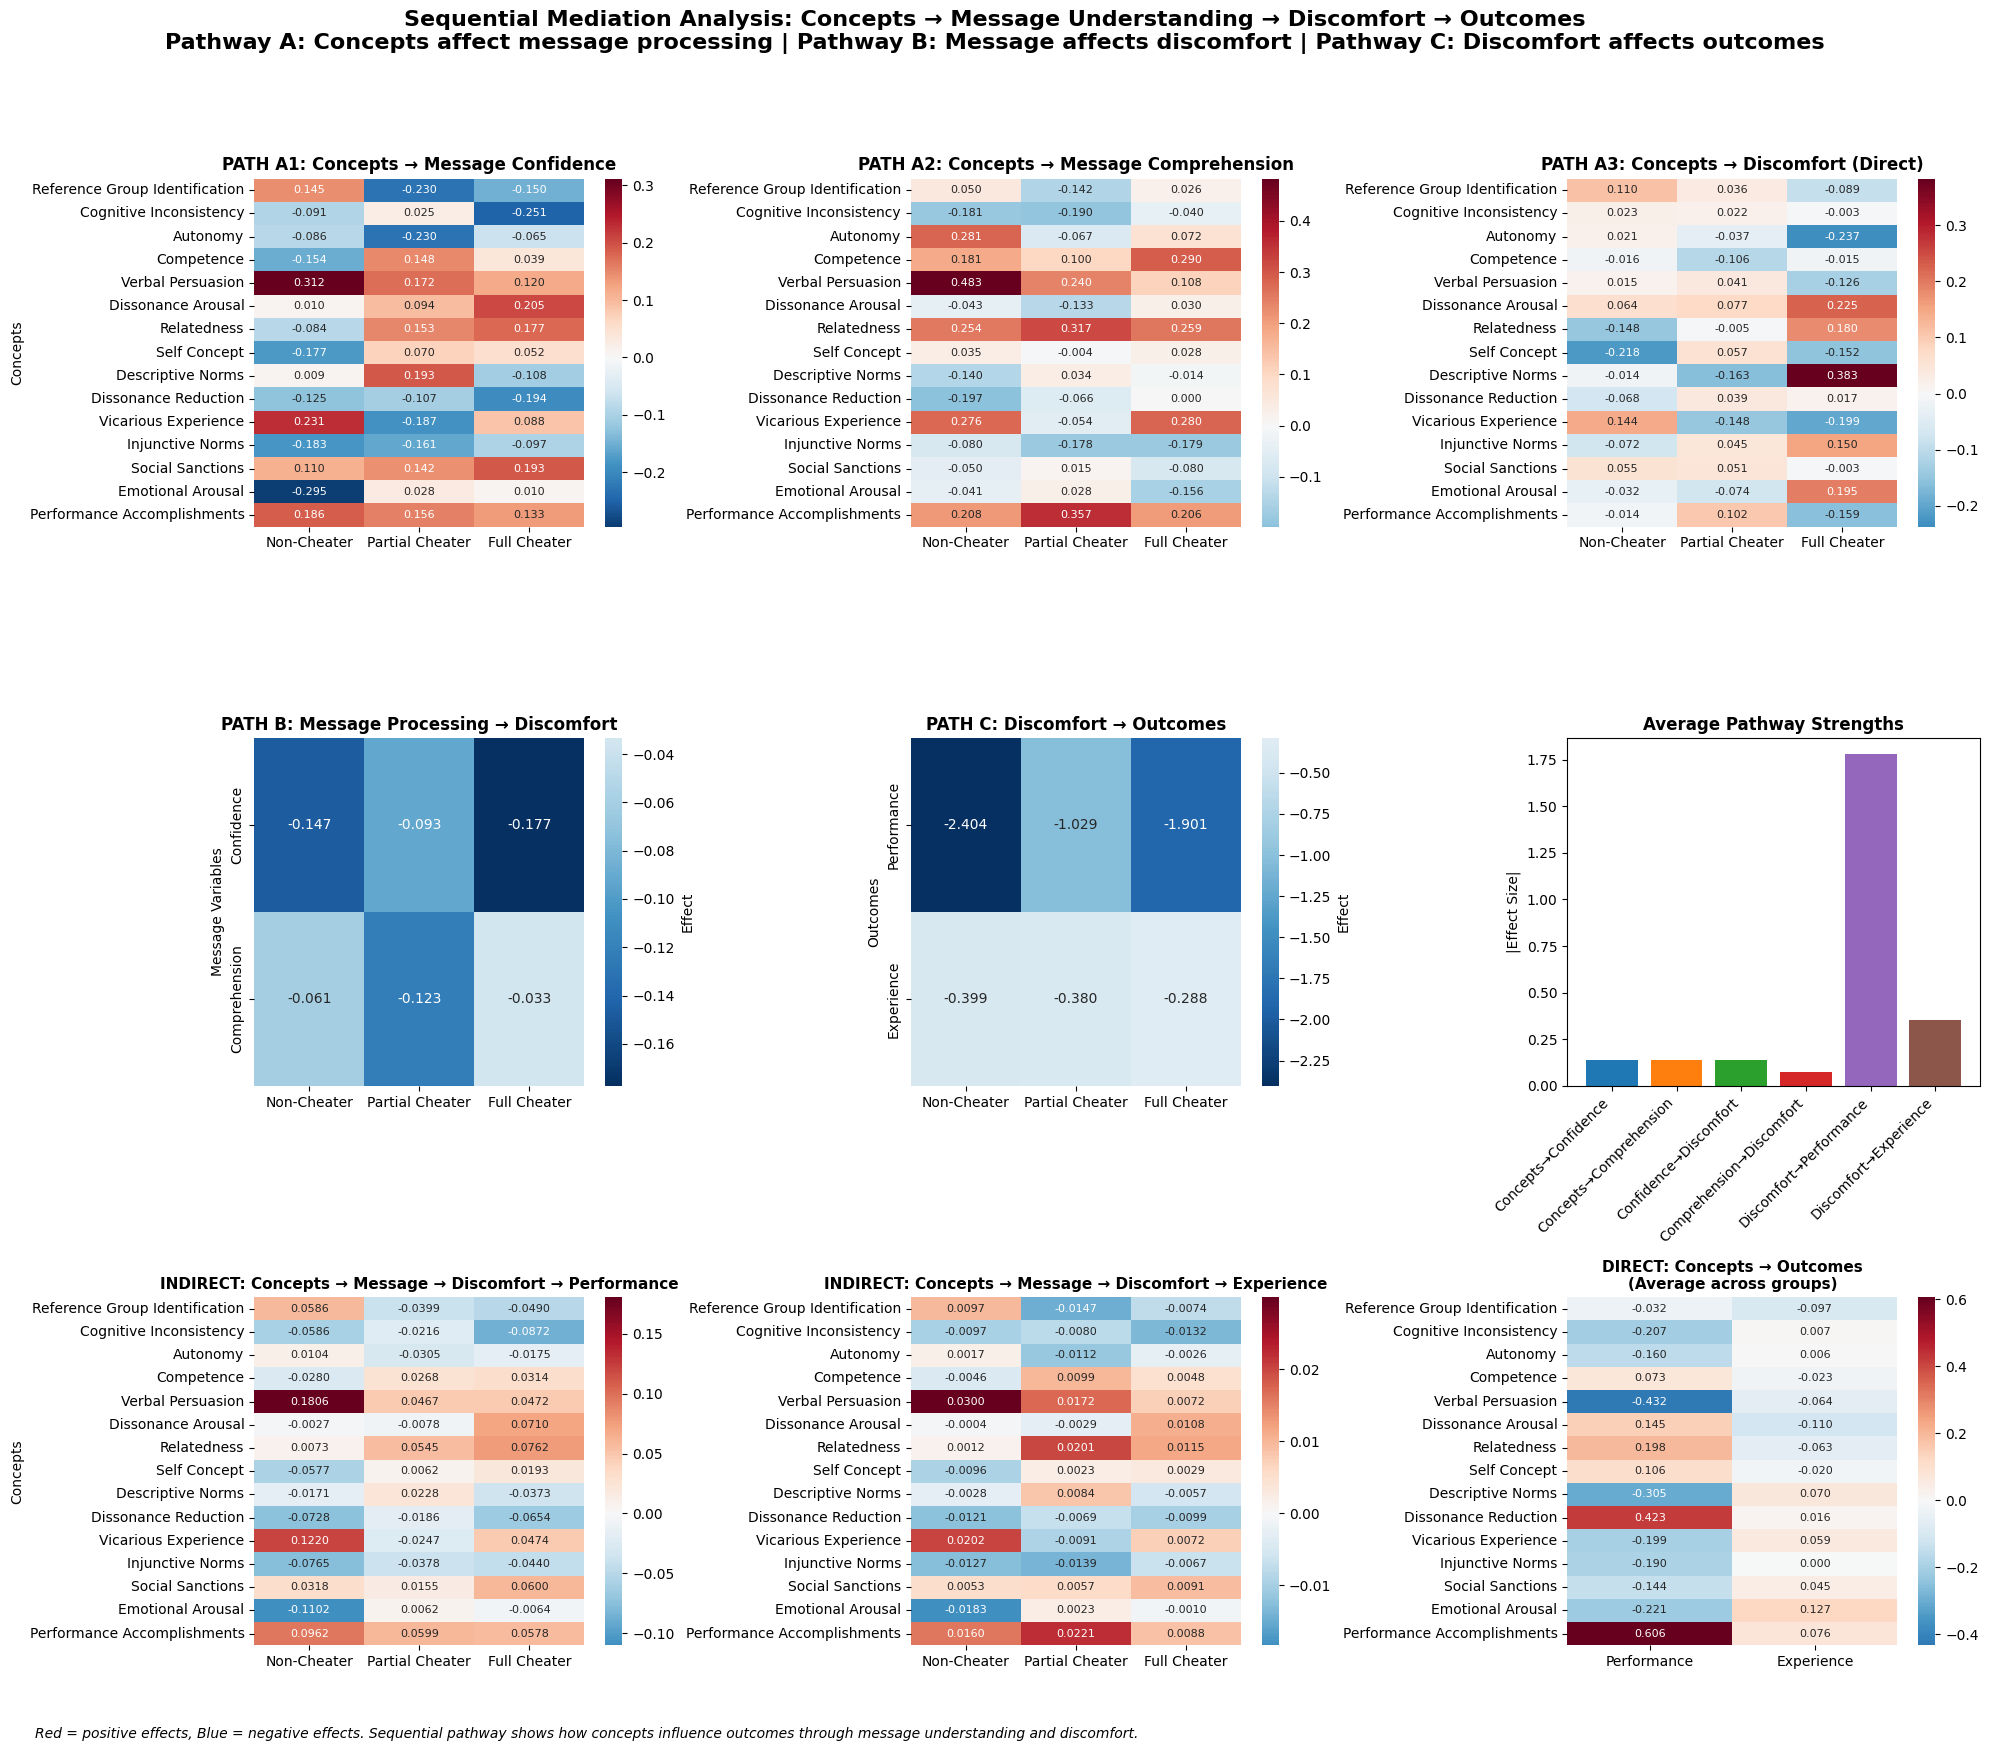

SEQUENTIAL MEDIATION SUMMARY

STRONGEST INDIRECT EFFECTS (Performance):
---------------------------------------------
Dissonance Arousal → Non-Cheater                0.1806
Relatedness → Non-Cheater                       0.1220
Verbal Persuasion → Non-Cheater                -0.1102
Vicarious Experience → Non-Cheater              0.0962
Cognitive Inconsistency → Full Cheater         -0.0872
Self Concept → Non-Cheater                     -0.0765
Emotional Arousal → Full Cheater                0.0762
Reference Group Identification → Non-Cheater   -0.0728
Dissonance Reduction → Full Cheater             0.0710
Reference Group Identification → Full Cheater  -0.0654

STRONGEST INDIRECT EFFECTS (Experience):
---------------------------------------------
Dissonance Arousal → Non-Cheater                0.0300
Vicarious Experience → Partial Cheater          0.0221
Relatedness → Non-Cheater                       0.0202
Emotional Arousal → Partial Cheater             0.0201
Verbal Persuasion → Non-

In [46]:
# ============================================================================
# SEQUENTIAL MEDIATION VISUALIZATION: Concepts → Message → Discomfort → Outcomes
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def visualize_sequential_mediation(trace_message, trace_discomfort, trace_outcome, concepts):
    """Create comprehensive visualization of sequential mediation pathway"""
    
    # Extract pathway effects
    conf_effects = trace_message.posterior['conf_concept_effects'].values.mean(axis=(0,1))  # [concept, group]
    comp_effects = trace_message.posterior['comp_concept_effects'].values.mean(axis=(0,1))
    
    conf_to_disc = trace_discomfort.posterior['conf_to_disc'].values.mean(axis=(0,1))  # [group]
    comp_to_disc = trace_discomfort.posterior['comp_to_disc'].values.mean(axis=(0,1))
    disc_concept_effects = trace_discomfort.posterior['disc_concept_effects'].values.mean(axis=(0,1))
    
    disc_to_perf = trace_outcome.posterior['disc_to_perf'].values.mean(axis=(0,1))  # [group]
    disc_to_exp = trace_outcome.posterior['disc_to_exp'].values.mean(axis=(0,1))
    perf_direct = trace_outcome.posterior['perf_direct'].values.mean(axis=(0,1))
    exp_direct = trace_outcome.posterior['exp_direct'].values.mean(axis=(0,1))
    
    # Order concepts consistently with previous mediation analysis
    concepts_ordered_mediation = [
        "reference_group_identification", "cognitive_inconsistency", "autonomy", "competence",
        "verbal_persuasion", "dissonance_arousal", "relatedness", "self_concept",
        "descriptive_norms", "dissonance_reduction", "vicarious_experience", "injunctive_norms",
        "social_sanctions", "emotional_arousal", "performance_accomplishments"
    ]
    
    # Create mapping from concepts to ordered indices
    concept_order_map = {concept: i for i, concept in enumerate(concepts)}
    ordered_indices = [concept_order_map[concept] for concept in concepts_ordered_mediation if concept in concept_order_map]
    
    # Reorder all effect matrices
    conf_effects = conf_effects[ordered_indices]
    comp_effects = comp_effects[ordered_indices]
    disc_concept_effects = disc_concept_effects[ordered_indices]
    perf_direct = perf_direct[ordered_indices]
    exp_direct = exp_direct[ordered_indices]
    
    # Setup with ordered labels
    concept_labels = [concepts_ordered_mediation[i].replace('_', ' ').title() for i in range(len(ordered_indices))]
    groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
    
    # Create 3x3 grid
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    
    # ========================================================================
    # ROW 1: CONCEPTS → MESSAGE PROCESSING
    # ========================================================================
    
    # Concepts → Confidence
    sns.heatmap(conf_effects, xticklabels=groups, yticklabels=concept_labels,
                cmap='RdBu_r', center=0, annot=True, fmt='.3f', 
                annot_kws={'size': 8}, ax=axes[0, 0])
    axes[0, 0].set_title('PATH A1: Concepts → Message Confidence', fontweight='bold', fontsize=12)
    axes[0, 0].set_ylabel('Concepts')
    
    # Concepts → Comprehension
    sns.heatmap(comp_effects, xticklabels=groups, yticklabels=concept_labels,
                cmap='RdBu_r', center=0, annot=True, fmt='.3f',
                annot_kws={'size': 8}, ax=axes[0, 1])
    axes[0, 1].set_title('PATH A2: Concepts → Message Comprehension', fontweight='bold', fontsize=12)
    
    # Concepts → Discomfort (Direct)
    sns.heatmap(disc_concept_effects, xticklabels=groups, yticklabels=concept_labels,
                cmap='RdBu_r', center=0, annot=True, fmt='.3f',
                annot_kws={'size': 8}, ax=axes[0, 2])
    axes[0, 2].set_title('PATH A3: Concepts → Discomfort (Direct)', fontweight='bold', fontsize=12)
    
    # ========================================================================
    # ROW 2: MESSAGE PROCESSING → DISCOMFORT → OUTCOMES
    # ========================================================================
    
    # Message → Discomfort
    message_to_disc = np.array([conf_to_disc, comp_to_disc])
    sns.heatmap(message_to_disc, xticklabels=groups, 
                yticklabels=['Confidence', 'Comprehension'],
                cmap='RdBu_r', center=0, annot=True, fmt='.3f',
                cbar_kws={'label': 'Effect'}, ax=axes[1, 0])
    axes[1, 0].set_title('PATH B: Message Processing → Discomfort', fontweight='bold', fontsize=12)
    axes[1, 0].set_ylabel('Message Variables')
    
    # Discomfort → Outcomes
    disc_to_outcomes = np.array([disc_to_perf, disc_to_exp])
    sns.heatmap(disc_to_outcomes, xticklabels=groups,
                yticklabels=['Performance', 'Experience'],
                cmap='RdBu_r', center=0, annot=True, fmt='.3f',
                cbar_kws={'label': 'Effect'}, ax=axes[1, 1])
    axes[1, 1].set_title('PATH C: Discomfort → Outcomes', fontweight='bold', fontsize=12)
    axes[1, 1].set_ylabel('Outcomes')
    
    # Summary pathway strengths
    pathway_strengths = []
    pathway_labels = []
    
    # Calculate average pathway strengths
    conf_avg = np.abs(conf_effects).mean()
    comp_avg = np.abs(comp_effects).mean()
    conf_disc_avg = np.abs(conf_to_disc).mean()
    comp_disc_avg = np.abs(comp_to_disc).mean()
    disc_perf_avg = np.abs(disc_to_perf).mean()
    disc_exp_avg = np.abs(disc_to_exp).mean()
    
    pathway_data = {
        'Concepts→Confidence': conf_avg,
        'Concepts→Comprehension': comp_avg,
        'Confidence→Discomfort': conf_disc_avg,
        'Comprehension→Discomfort': comp_disc_avg,
        'Discomfort→Performance': disc_perf_avg,
        'Discomfort→Experience': disc_exp_avg
    }
    
    bars = axes[1, 2].bar(range(len(pathway_data)), list(pathway_data.values()), 
                         color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    axes[1, 2].set_xticks(range(len(pathway_data)))
    axes[1, 2].set_xticklabels(list(pathway_data.keys()), rotation=45, ha='right')
    axes[1, 2].set_title('Average Pathway Strengths', fontweight='bold', fontsize=12)
    axes[1, 2].set_ylabel('|Effect Size|')
    
    # ========================================================================
    # ROW 3: INDIRECT EFFECTS & TOTAL EFFECTS
    # ========================================================================
    
    # Calculate indirect effects: Concepts → Message → Discomfort → Performance
    indirect_conf_perf = np.array([[conf_effects[i, j] * conf_to_disc[j] * disc_to_perf[j] 
                                   for j in range(3)] for i in range(len(concepts))])
    indirect_comp_perf = np.array([[comp_effects[i, j] * comp_to_disc[j] * disc_to_perf[j] 
                                   for j in range(3)] for i in range(len(concepts))])
    total_indirect_perf = indirect_conf_perf + indirect_comp_perf
    
    # Indirect → Performance
    sns.heatmap(total_indirect_perf, xticklabels=groups, yticklabels=concept_labels,
                cmap='RdBu_r', center=0, annot=True, fmt='.4f',
                annot_kws={'size': 8}, ax=axes[2, 0])
    axes[2, 0].set_title('INDIRECT: Concepts → Message → Discomfort → Performance', 
                        fontweight='bold', fontsize=11)
    axes[2, 0].set_ylabel('Concepts')
    
    # Indirect → Experience
    indirect_conf_exp = np.array([[conf_effects[i, j] * conf_to_disc[j] * disc_to_exp[j] 
                                  for j in range(3)] for i in range(len(concepts))])
    indirect_comp_exp = np.array([[comp_effects[i, j] * comp_to_disc[j] * disc_to_exp[j] 
                                  for j in range(3)] for i in range(len(concepts))])
    total_indirect_exp = indirect_conf_exp + indirect_comp_exp
    
    sns.heatmap(total_indirect_exp, xticklabels=groups, yticklabels=concept_labels,
                cmap='RdBu_r', center=0, annot=True, fmt='.4f',
                annot_kws={'size': 8}, ax=axes[2, 1])
    axes[2, 1].set_title('INDIRECT: Concepts → Message → Discomfort → Experience', 
                        fontweight='bold', fontsize=11)
    
    # Direct effects (for comparison)
    direct_effects = np.column_stack([perf_direct.mean(axis=1), exp_direct.mean(axis=1)])
    sns.heatmap(direct_effects, xticklabels=['Performance', 'Experience'], 
                yticklabels=concept_labels,
                cmap='RdBu_r', center=0, annot=True, fmt='.3f',
                annot_kws={'size': 8}, ax=axes[2, 2])
    axes[2, 2].set_title('DIRECT: Concepts → Outcomes\n(Average across groups)', 
                        fontweight='bold', fontsize=11)
    
    # ========================================================================
    # STYLING AND LAYOUT
    # ========================================================================
    
    plt.suptitle('Sequential Mediation Analysis: Concepts → Message Understanding → Discomfort → Outcomes\n'
                 'Pathway A: Concepts affect message processing | Pathway B: Message affects discomfort | Pathway C: Discomfort affects outcomes',
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Add interpretive text
    fig.text(0.02, 0.02, 
             'Red = positive effects, Blue = negative effects. Sequential pathway shows how concepts influence outcomes through message understanding and discomfort.',
             fontsize=10, style='italic')
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.94])
    plt.show()
    
    return {
        'indirect_performance': total_indirect_perf,
        'indirect_experience': total_indirect_exp,
        'direct_performance': perf_direct,
        'direct_experience': exp_direct,
        'pathway_strengths': pathway_data
    }

def print_sequential_mediation_summary(results, concepts):
    """Print summary of sequential mediation results"""
    
    concept_labels = [c.replace('_', ' ').title() for c in concepts]
    groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
    
    print("="*80)
    print("SEQUENTIAL MEDIATION SUMMARY")
    print("="*80)
    
    print("\nSTRONGEST INDIRECT EFFECTS (Performance):")
    print("-" * 45)
    perf_effects = []
    for i, concept in enumerate(concept_labels):
        for j, group in enumerate(groups):
            effect = results['indirect_performance'][i, j]
            perf_effects.append((abs(effect), f"{concept} → {group}", effect))
    
    perf_effects.sort(reverse=True)
    for _, pathway, effect in perf_effects[:10]:
        print(f"{pathway:45} {effect:8.4f}")
    
    print("\nSTRONGEST INDIRECT EFFECTS (Experience):")
    print("-" * 45)
    exp_effects = []
    for i, concept in enumerate(concept_labels):
        for j, group in enumerate(groups):
            effect = results['indirect_experience'][i, j]
            exp_effects.append((abs(effect), f"{concept} → {group}", effect))
    
    exp_effects.sort(reverse=True)
    for _, pathway, effect in exp_effects[:10]:
        print(f"{pathway:45} {effect:8.4f}")
    
    print("\nPATHWAY STRENGTHS (Average |Effect|):")
    print("-" * 35)
    for pathway, strength in results['pathway_strengths'].items():
        print(f"{pathway:25} {strength:8.4f}")

# Run the visualization
print("Creating sequential mediation visualization...")
results = visualize_sequential_mediation(trace_message, trace_discomfort, trace_outcome, concepts)
print_sequential_mediation_summary(results, concepts)